<div style="text-align: center; padding: 2em 1em; background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); border-radius: 12px; color: white; margin-bottom: 2em;">
  <h1 style="margin: 0; font-size: 2.5em; font-weight: 600; letter-spacing: -0.02em;">Метрики привлечения пользователей (User Acquisition Metrics)</h1>
  <p style="margin: 0.5em 0 0 0; font-size: 1.2em; opacity: 0.95;">Полное руководство по метрикам UA в игровой индустрии</p>
</div>

<div style="padding: 1.5em; background: #f8f9fa; border-left: 4px solid #4facfe; border-radius: 6px; margin: 1em 0;">
  <p style="margin: 0; color: #2c3e50; line-height: 1.6; font-weight: 400;">
    <strong>User Acquisition (UA)</strong> — метрики, показывающие эффективность привлечения пользователей в игру.
    Эти метрики критически важны для оценки окупаемости маркетинговых кампаний, оптимизации каналов привлечения,
    и принятия решений о масштабировании. Правильный UA баланс между стоимостью привлечения (CAC/CPI) и пожизненной ценностью пользователя (LTV).
  </p>
</div>


In [63]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Библиотеки загружены успешно")


✅ Библиотеки загружены успешно


## Генерация синтетических данных

Для демонстрации всех метрик создадим синтетический датасет с:
- Маркетинговыми кампаниями по разным каналам
- Impression, clicks, installs (воронка привлечения)
- Стоимостью по каналам
- Creative вариантами
- Organic vs Paid установками
- Связью с retention и monetization


In [64]:
# Устанавливаем seed для воспроизводимости
np.random.seed(42)

# Параметры датасета
n_users = 15000  # Количество пользователей (включая органику)
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 3, 31)  # 3 месяца данных
n_days = (end_date - start_date).days

# Определяем каналы привлечения с параметрами
channels_config = {
    'Organic': {
        'share': 0.40,  # 40% органических установок
        'cpi': 0.0,
        'retention_d1': 0.45,
        'retention_d7': 0.22,
        'paying_rate': 0.06,
        'arpu_multiplier': 1.2  # Органика лучше монетизируется
    },
    'Facebook': {
        'share': 0.25,
        'cpi': 2.50,
        'retention_d1': 0.38,
        'retention_d7': 0.18,
        'paying_rate': 0.05,
        'arpu_multiplier': 1.0
    },
    'Google UAC': {
        'share': 0.15,
        'cpi': 3.20,
        'retention_d1': 0.40,
        'retention_d7': 0.19,
        'paying_rate': 0.055,
        'arpu_multiplier': 1.1
    },
    'TikTok': {
        'share': 0.10,
        'cpi': 2.80,
        'retention_d1': 0.35,
        'retention_d7': 0.15,
        'paying_rate': 0.04,
        'arpu_multiplier': 0.9
    },
    'Unity Ads': {
        'share': 0.05,
        'cpi': 1.80,
        'retention_d1': 0.30,
        'retention_d7': 0.12,
        'paying_rate': 0.03,
        'arpu_multiplier': 0.7
    },
    'AppLovin': {
        'share': 0.03,
        'cpi': 1.60,
        'retention_d1': 0.28,
        'retention_d7': 0.10,
        'paying_rate': 0.025,
        'arpu_multiplier': 0.6
    },
    'ironSource': {
        'share': 0.02,
        'cpi': 1.50,
        'retention_d1': 0.26,
        'retention_d7': 0.09,
        'paying_rate': 0.02,
        'arpu_multiplier': 0.5
    }
}

# Создаем пользователей с распределением по каналам
channel_names = list(channels_config.keys())
channel_shares = [channels_config[ch]['share'] for ch in channel_names]

users_data = []

for user_id in range(n_users):
    # Выбираем канал
    channel = np.random.choice(channel_names, p=channel_shares)
    config = channels_config[channel]
    
    # Дата установки
    install_date = start_date + timedelta(days=np.random.randint(0, n_days))
    
    # Для платных каналов выбираем creative
    if channel != 'Organic':
        creative = np.random.choice(['Creative_A', 'Creative_B', 'Creative_C', 'Creative_D'])
        campaign_id = f"{channel.replace(' ', '_')}_{creative}_{install_date.strftime('%Y%m')}"
    else:
        creative = None
        campaign_id = 'Organic'
    
    # CPI с небольшим шумом для платных каналов
    if config['cpi'] > 0:
        actual_cpi = config['cpi'] * np.random.uniform(0.8, 1.2)
    else:
        actual_cpi = 0.0
    
    users_data.append({
        'user_id': f'user_{user_id:05d}',
        'install_date': install_date,
        'channel': channel,
        'channel_type': 'Organic' if channel == 'Organic' else 'Paid',
        'creative': creative,
        'campaign_id': campaign_id,
        'cpi': round(actual_cpi, 2),
        'country': np.random.choice(['US', 'EU', 'JP', 'KR', 'CN', 'BR', 'Other'], 
                                   p=[0.30, 0.25, 0.10, 0.08, 0.07, 0.05, 0.15])
    })

users_df = pd.DataFrame(users_data)

print(f"✅ Создано {len(users_df)} пользователей")
print(f"\nРаспределение по каналам:")
print(users_df['channel'].value_counts().sort_values(ascending=False))
print(f"\nOrganic vs Paid:")
print(users_df['channel_type'].value_counts())
print(f"\nПример данных пользователей:")
print(users_df.head(10))


✅ Создано 15000 пользователей

Распределение по каналам:
channel
Organic       5958
Facebook      3770
Google UAC    2343
TikTok        1459
Unity Ads      768
AppLovin       424
ironSource     278
Name: count, dtype: int64

Organic vs Paid:
channel_type
Paid       9042
Organic    5958
Name: count, dtype: int64

Пример данных пользователей:
      user_id install_date   channel channel_type    creative  \
0  user_00000   2024-01-15   Organic      Organic        None   
1  user_00001   2024-03-23  Facebook         Paid  Creative_C   
2  user_00002   2024-01-24  Facebook         Paid  Creative_C   
3  user_00003   2024-02-07    TikTok         Paid  Creative_B   
4  user_00004   2024-01-22   Organic      Organic        None   
5  user_00005   2024-02-28   Organic      Organic        None   
6  user_00006   2024-02-29   Organic      Organic        None   
7  user_00007   2024-02-16  Facebook         Paid  Creative_B   
8  user_00008   2024-01-03  Facebook         Paid  Creative_A   
9  user

In [65]:
# Генерируем данные о воронке привлечения (impression → click → install)
# Для каждого установленного пользователя создаем обратную воронку

funnel_data = []

for idx, user in users_df.iterrows():
    if user['channel'] == 'Organic':
        # Для органики нет impression/clicks
        continue
    
    channel = user['channel']
    install_date = user['install_date']
    campaign_id = user['campaign_id']
    creative = user['creative']
    
    # У нас есть 1 install, работаем в обратную сторону
    # CTR (click-to-install) обычно 15-30%
    ctr_install = np.random.uniform(0.15, 0.30)
    clicks_needed = int(1 / ctr_install)
    
    # CTR (impression-to-click) обычно 2-8%
    ctr_click = np.random.uniform(0.02, 0.08)
    impressions_needed = int(clicks_needed / ctr_click)
    
    funnel_data.append({
        'date': install_date,
        'channel': channel,
        'campaign_id': campaign_id,
        'creative': creative,
        'impressions': impressions_needed,
        'clicks': clicks_needed,
        'installs': 1,
        'spend': user['cpi']
    })

# Агрегируем по дате, каналу и creative
funnel_df = pd.DataFrame(funnel_data)
funnel_aggregated = funnel_df.groupby(['date', 'channel', 'campaign_id', 'creative']).agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'installs': 'sum',
    'spend': 'sum'
}).reset_index()

# Рассчитываем метрики воронки
funnel_aggregated['ctr'] = funnel_aggregated['clicks'] / funnel_aggregated['impressions']
funnel_aggregated['cvr'] = funnel_aggregated['installs'] / funnel_aggregated['clicks']
funnel_aggregated['ipm'] = (funnel_aggregated['installs'] / funnel_aggregated['impressions']) * 1000
funnel_aggregated['cpi'] = funnel_aggregated['spend'] / funnel_aggregated['installs']

print(f"✅ Создано {len(funnel_aggregated)} записей воронки привлечения")
print(f"\nПример данных воронки:")
print(funnel_aggregated.head(10))


✅ Создано 1838 записей воронки привлечения

Пример данных воронки:
        date     channel                   campaign_id    creative  \
0 2024-01-01    AppLovin    AppLovin_Creative_A_202401  Creative_A   
1 2024-01-01    AppLovin    AppLovin_Creative_D_202401  Creative_D   
2 2024-01-01    Facebook    Facebook_Creative_A_202401  Creative_A   
3 2024-01-01    Facebook    Facebook_Creative_B_202401  Creative_B   
4 2024-01-01    Facebook    Facebook_Creative_C_202401  Creative_C   
5 2024-01-01    Facebook    Facebook_Creative_D_202401  Creative_D   
6 2024-01-01  Google UAC  Google_UAC_Creative_A_202401  Creative_A   
7 2024-01-01  Google UAC  Google_UAC_Creative_B_202401  Creative_B   
8 2024-01-01  Google UAC  Google_UAC_Creative_C_202401  Creative_C   
9 2024-01-01  Google UAC  Google_UAC_Creative_D_202401  Creative_D   

   impressions  clicks  installs  spend       ctr       cvr        ipm  \
0          136       6         2   2.91  0.044118  0.333333  14.705882   
1          189

In [66]:
# Генерируем активность пользователей (для расчета retention)
activities = []

for idx, user in users_df.iterrows():
    user_id = user['user_id']
    install_date = user['install_date']
    channel = user['channel']
    config = channels_config[channel]
    
    # День установки всегда активен
    activities.append({
        'user_id': user_id,
        'event_date': install_date,
        'day_since_install': 0
    })
    
    # Генерируем активность на основе retention профиля канала
    max_days = min(60, (end_date - install_date).days)
    
    for day in range(1, max_days + 1):
        # Вероятность активности с экспоненциальным спадом
        if day == 1:
            probability = config['retention_d1']
        elif day <= 7:
            # Интерполяция между D1 и D7
            probability = config['retention_d1'] - (config['retention_d1'] - config['retention_d7']) * (day - 1) / 6
        else:
            # После D7 продолжаем спад
            decay_rate = 0.03
            probability = config['retention_d7'] * np.exp(-decay_rate * (day - 7))
        
        if np.random.random() < probability:
            event_date = install_date + timedelta(days=day)
            if event_date <= end_date:
                activities.append({
                    'user_id': user_id,
                    'event_date': event_date,
                    'day_since_install': day
                })

activities_df = pd.DataFrame(activities)
activities_df['event_date'] = pd.to_datetime(activities_df['event_date'])

print(f"✅ Сгенерировано {len(activities_df)} событий активности")
print(f"\nПример данных активности:")
print(activities_df.head(10))


✅ Сгенерировано 97031 событий активности

Пример данных активности:
      user_id event_date  day_since_install
0  user_00000 2024-01-15                  0
1  user_00000 2024-01-16                  1
2  user_00000 2024-01-17                  2
3  user_00000 2024-01-20                  5
4  user_00000 2024-02-02                 18
5  user_00000 2024-02-12                 28
6  user_00000 2024-02-13                 29
7  user_00001 2024-03-23                  0
8  user_00001 2024-03-24                  1
9  user_00001 2024-03-25                  2


In [67]:
# Генерируем покупки (для расчета LTV и ROAS)
purchases = []
purchase_id_counter = 0

# Типы покупок
purchase_types = {
    'starter_pack': {'price': 0.99, 'weight': 0.30},
    'small_gems': {'price': 1.99, 'weight': 0.25},
    'medium_gems': {'price': 4.99, 'weight': 0.20},
    'large_gems': {'price': 9.99, 'weight': 0.15},
    'mega_pack': {'price': 19.99, 'weight': 0.07},
    'ultimate_pack': {'price': 49.99, 'weight': 0.03}
}

purchase_type_names = list(purchase_types.keys())
purchase_weights = [v['weight'] for v in purchase_types.values()]

for idx, user in users_df.iterrows():
    user_id = user['user_id']
    channel = user['channel']
    install_date = user['install_date']
    config = channels_config[channel]
    
    # Решаем, будет ли пользователь платить
    if np.random.random() > config['paying_rate']:
        continue  # Не платит
    
    # Количество покупок для плательщика (с распределением)
    num_purchases = np.random.choice([1, 2, 3, 4, 5, 10, 20], 
                                    p=[0.40, 0.25, 0.15, 0.10, 0.05, 0.03, 0.02])
    
    # Первая покупка в течение 14 дней
    days_to_first_purchase = np.random.randint(0, 14)
    first_purchase_date = install_date + timedelta(days=days_to_first_purchase)
    
    if first_purchase_date > end_date:
        continue
    
    for i in range(num_purchases):
        purchase_id_counter += 1
        
        if i == 0:
            purchase_date = first_purchase_date
        else:
            days_between = np.random.exponential(scale=10)
            purchase_date = first_purchase_date + timedelta(days=int(days_between * (i)))
        
        if purchase_date > end_date:
            break
        
        # Выбираем тип покупки
        purchase_type = np.random.choice(purchase_type_names, p=purchase_weights)
        price = purchase_types[purchase_type]['price'] * config['arpu_multiplier']
        
        purchases.append({
            'purchase_id': f'purchase_{purchase_id_counter:07d}',
            'user_id': user_id,
            'purchase_date': purchase_date,
            'purchase_type': purchase_type,
            'amount_usd': round(price, 2),
            'days_since_install': (purchase_date - install_date).days
        })

purchases_df = pd.DataFrame(purchases)

print(f"✅ Сгенерировано {len(purchases_df)} покупок")
print(f"\nПлательщиков: {purchases_df['user_id'].nunique()}")
print(f"\nПример данных покупок:")
print(purchases_df.head(10))


✅ Сгенерировано 1282 покупок

Плательщиков: 661

Пример данных покупок:
        purchase_id     user_id purchase_date  purchase_type  amount_usd  \
0  purchase_0000001  user_00013    2024-01-13     large_gems        9.99   
1  purchase_0000002  user_00075    2024-01-30     large_gems       11.99   
2  purchase_0000003  user_00075    2024-02-01      mega_pack       23.99   
3  purchase_0000004  user_00137    2024-03-04     small_gems        2.39   
4  purchase_0000006  user_00166    2024-01-12    medium_gems        4.99   
5  purchase_0000007  user_00166    2024-01-18    medium_gems        4.99   
6  purchase_0000008  user_00166    2024-01-30    medium_gems        4.99   
7  purchase_0000009  user_00166    2024-01-17  ultimate_pack       49.99   
8  purchase_0000010  user_00170    2024-02-06    medium_gems        5.99   
9  purchase_0000011  user_00170    2024-02-18     small_gems        2.39   

   days_since_install  
0                   9  
1                   6  
2                  

In [68]:
# Объединяем данные для удобного анализа
# Добавляем к users_df информацию о retention и revenue

# D1 Retention
d1_activity = activities_df[activities_df['day_since_install'] == 1][['user_id']].drop_duplicates()
d1_activity['d1_retained'] = True
users_df = users_df.merge(d1_activity, on='user_id', how='left')
users_df['d1_retained'] = users_df['d1_retained'].fillna(False)

# D7 Retention
d7_activity = activities_df[activities_df['day_since_install'] == 7][['user_id']].drop_duplicates()
d7_activity['d7_retained'] = True
users_df = users_df.merge(d7_activity, on='user_id', how='left')
users_df['d7_retained'] = users_df['d7_retained'].fillna(False)

# Revenue per user
user_revenue = purchases_df.groupby('user_id')['amount_usd'].sum().reset_index()
user_revenue.columns = ['user_id', 'total_revenue']
users_df = users_df.merge(user_revenue, on='user_id', how='left')
users_df['total_revenue'] = users_df['total_revenue'].fillna(0)

# Количество дней в игре (для расчета LTV)
users_df['days_in_game'] = (end_date - users_df['install_date']).dt.days

print("✅ Данные объединены")
print(f"\nПример итоговых данных пользователей:")
print(users_df.head(10))


✅ Данные объединены

Пример итоговых данных пользователей:
      user_id install_date   channel channel_type    creative  \
0  user_00000   2024-01-15   Organic      Organic        None   
1  user_00001   2024-03-23  Facebook         Paid  Creative_C   
2  user_00002   2024-01-24  Facebook         Paid  Creative_C   
3  user_00003   2024-02-07    TikTok         Paid  Creative_B   
4  user_00004   2024-01-22   Organic      Organic        None   
5  user_00005   2024-02-28   Organic      Organic        None   
6  user_00006   2024-02-29   Organic      Organic        None   
7  user_00007   2024-02-16  Facebook         Paid  Creative_B   
8  user_00008   2024-01-03  Facebook         Paid  Creative_A   
9  user_00009   2024-01-04   Organic      Organic        None   

                  campaign_id   cpi country  d1_retained  d7_retained  \
0                     Organic  0.00      CN         True        False   
1  Facebook_Creative_C_202403  2.06   Other         True        False   
2  Fac

<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">1. Installs (Установки)</h2>
</div>

### 📍 Определение

**Installs (установки)** — общее количество установок игры за определенный период.

### 📍 Формула расчета

$$
\text{Installs} = \text{Количество установок за период}
$$

Можно разбить на:
- **Total Installs** — все установки
- **Organic Installs** — органические установки
- **Paid Installs** — платные установки

### 📍 Зачем нужна метрика

Installs — **базовая метрика роста**, которая:

1. **Показывает масштаб привлечения**
   - Сколько новых пользователей получаем
   - Динамику роста базы

2. **Используется для расчета других метрик**
   - CPI = Spend / Installs
   - Install Rate = Installs / Clicks
   - IPM = (Installs / Impressions) × 1000

3. **Индикатор эффективности маркетинга**
   - Сравнение каналов по объему
   - Оценка влияния кампаний

### 📍 Что показывает

- **Высокие installs** — активный рост, хороший маркетинг
- **Низкие installs** — проблемы с видимостью, слабый маркетинг
- **Растущий тренд** — масштабирование работает
- **Падающий тренд** — проблемы с ASO, сезонность, конкуренция

### 📍 На что влияет

✅ **DAU/MAU** — больше установок → больше активных пользователей

✅ **Revenue** — больше пользователей → больше потенциального дохода

✅ **Virality** — больше пользователей → больше возможностей для виральности

### 📍 Что на нее влияет

✅ **Положительные факторы:**
- Увеличение маркетингового бюджета
- Эффективные креативы
- Хорошее ASO (App Store Optimization)
- Виральность и word-of-mouth
- Сезонность (праздники, каникулы)
- Feature на главной странице сторов
- Положительные отзывы и высокий рейтинг

❌ **Негативные факторы:**
- Снижение маркетингового бюджета
- Плохие креативы
- Низкий рейтинг в сторах
- Технические проблемы
- Сильная конкуренция
- Плохое ASO

### 📍 Бенчмарки по жанрам

Бенчмарки сильно зависят от бюджета, но типичные паттерны:

| Жанр | Organic Share | Paid Share | Примечания |
|------|---------------|------------|------------|
| **Hypercasual** | 10-20% | 80-90% | Сильная зависимость от UA |
| **Casual** | 20-35% | 65-80% | Баланс между paid и organic |
| **Mid-core** | 30-45% | 55-70% | Больше органики |
| **Strategy** | 35-50% | 50-65% | Сильный word-of-mouth |
| **RTS** | 40-55% | 45-60% | Высокая органика, преданная аудитория |
| **RPG** | 35-50% | 50-65% | Зависит от IP и качества |
| **Puzzle** | 25-40% | 60-75% | Средняя зависимость от UA |

### 📍 Как улучшить

**Органические установки:**
1. Улучшить ASO (keywords, screenshots, videos)
2. Повысить рейтинг в сторах
3. Увеличить виральность игры
4. PR и media coverage
5. Community building (Discord, социальные сети)

**Платные установки:**
1. Увеличить бюджет на эффективные каналы
2. Оптимизировать креативы
3. Улучшить таргетинг
4. Тестировать новые каналы
5. A/B тестирование кампаний


### 📍 Расчет на Python


In [69]:
# Расчет общего количества установок
total_installs = len(users_df)
organic_installs = len(users_df[users_df['channel'] == 'Organic'])
paid_installs = len(users_df[users_df['channel'] != 'Organic'])

print("=" * 60)
print("INSTALLS METRICS")
print("=" * 60)
print(f"Total Installs: {total_installs:,}")
print(f"Organic Installs: {organic_installs:,} ({organic_installs/total_installs*100:.1f}%)")
print(f"Paid Installs: {paid_installs:,} ({paid_installs/total_installs*100:.1f}%)")
print("=" * 60)

# Разбивка по каналам
installs_by_channel = users_df['channel'].value_counts().sort_values(ascending=False)
print("\nInstalls by Channel:")
for channel, count in installs_by_channel.items():
    percentage = (count / total_installs) * 100
    print(f"  {channel:15s}: {count:5,} ({percentage:5.1f}%)")

# Динамика установок по дням
daily_installs = users_df.groupby('install_date').size().reset_index(name='installs')
daily_installs['date'] = daily_installs['install_date']
daily_installs = daily_installs.set_index('date')

print(f"\nDaily Installs Statistics:")
print(f"  Average: {daily_installs['installs'].mean():.1f} installs/day")
print(f"  Max: {daily_installs['installs'].max()} installs/day")
print(f"  Min: {daily_installs['installs'].min()} installs/day")
print(f"  Std: {daily_installs['installs'].std():.1f}")


INSTALLS METRICS
Total Installs: 15,000
Organic Installs: 5,958 (39.7%)
Paid Installs: 9,042 (60.3%)

Installs by Channel:
  Organic        : 5,958 ( 39.7%)
  Facebook       : 3,770 ( 25.1%)
  Google UAC     : 2,343 ( 15.6%)
  TikTok         : 1,459 (  9.7%)
  Unity Ads      :   768 (  5.1%)
  AppLovin       :   424 (  2.8%)
  ironSource     :   278 (  1.9%)

Daily Installs Statistics:
  Average: 166.7 installs/day
  Max: 197 installs/day
  Min: 140 installs/day
  Std: 12.7


### 📍 Визуализация


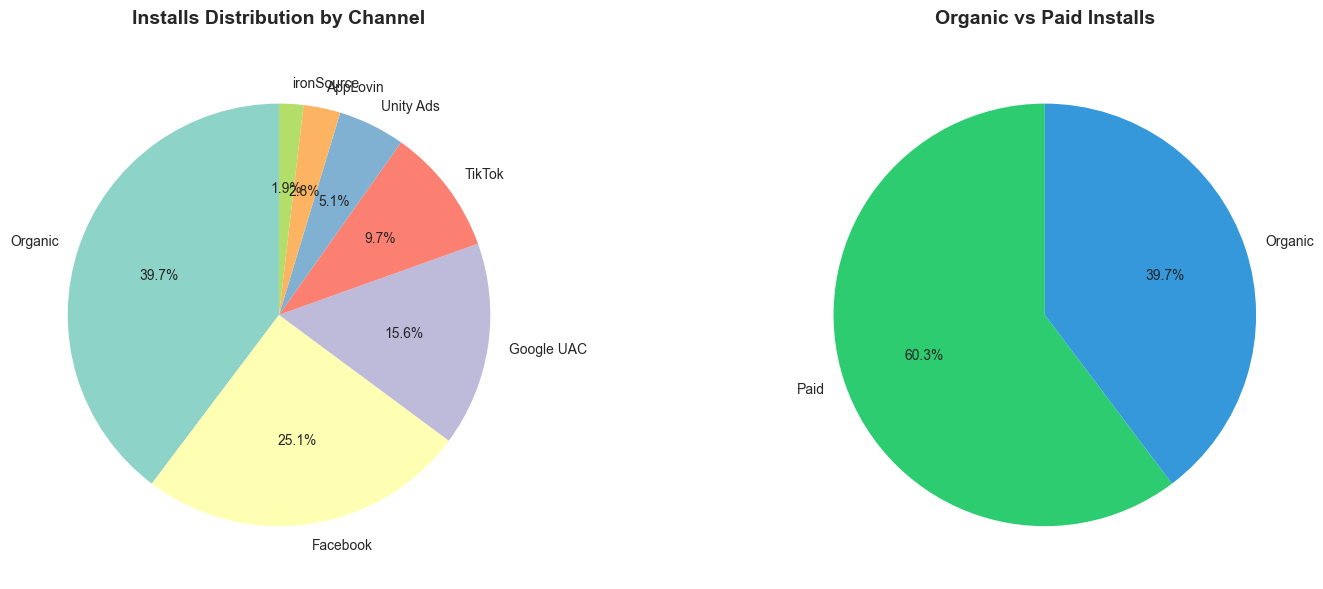

In [70]:
# График 1: Распределение установок по каналам (pie chart)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart всех каналов
ax1 = axes[0]
colors = sns.color_palette('Set3', len(installs_by_channel))
wedges, texts, autotexts = ax1.pie(installs_by_channel.values, 
                                     labels=installs_by_channel.index,
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     startangle=90)
ax1.set_title('Installs Distribution by Channel', fontsize=14, fontweight='bold', pad=20)

# Pie chart Organic vs Paid
ax2 = axes[1]
organic_vs_paid = users_df['channel_type'].value_counts()
colors_simple = ['#2ecc71', '#3498db']
wedges, texts, autotexts = ax2.pie(organic_vs_paid.values,
                                     labels=organic_vs_paid.index,
                                     autopct='%1.1f%%',
                                     colors=colors_simple,
                                     startangle=90)
ax2.set_title('Organic vs Paid Installs', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


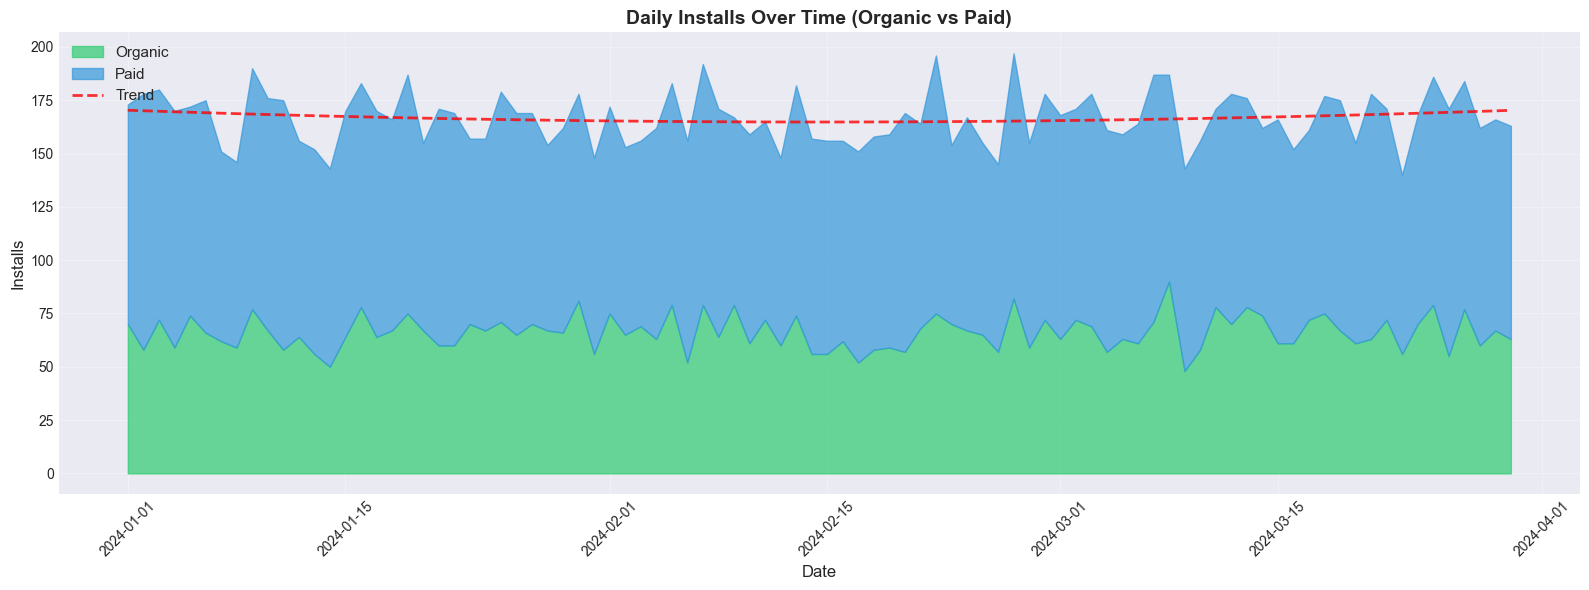

In [71]:
# График 2: Динамика установок по дням (с разбивкой на organic/paid)
daily_installs_by_type = users_df.groupby(['install_date', 'channel_type']).size().reset_index(name='installs')
daily_installs_pivot = daily_installs_by_type.pivot(index='install_date', columns='channel_type', values='installs').fillna(0)

fig, ax = plt.subplots(figsize=(16, 6))

# Stacked area chart
ax.fill_between(daily_installs_pivot.index, 0, daily_installs_pivot.get('Organic', 0),
                label='Organic', alpha=0.7, color='#2ecc71')
ax.fill_between(daily_installs_pivot.index, daily_installs_pivot.get('Organic', 0),
                daily_installs_pivot.get('Organic', 0) + daily_installs_pivot.get('Paid', 0),
                label='Paid', alpha=0.7, color='#3498db')

# Добавляем линию тренда для total
total_by_day = daily_installs_pivot.sum(axis=1)
z = np.polyfit(range(len(total_by_day)), total_by_day.values, 2)
p = np.poly1d(z)
ax.plot(daily_installs_pivot.index, p(range(len(total_by_day))), 
        "r--", linewidth=2, label='Trend', alpha=0.8)

ax.set_title('Daily Installs Over Time (Organic vs Paid)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Installs', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


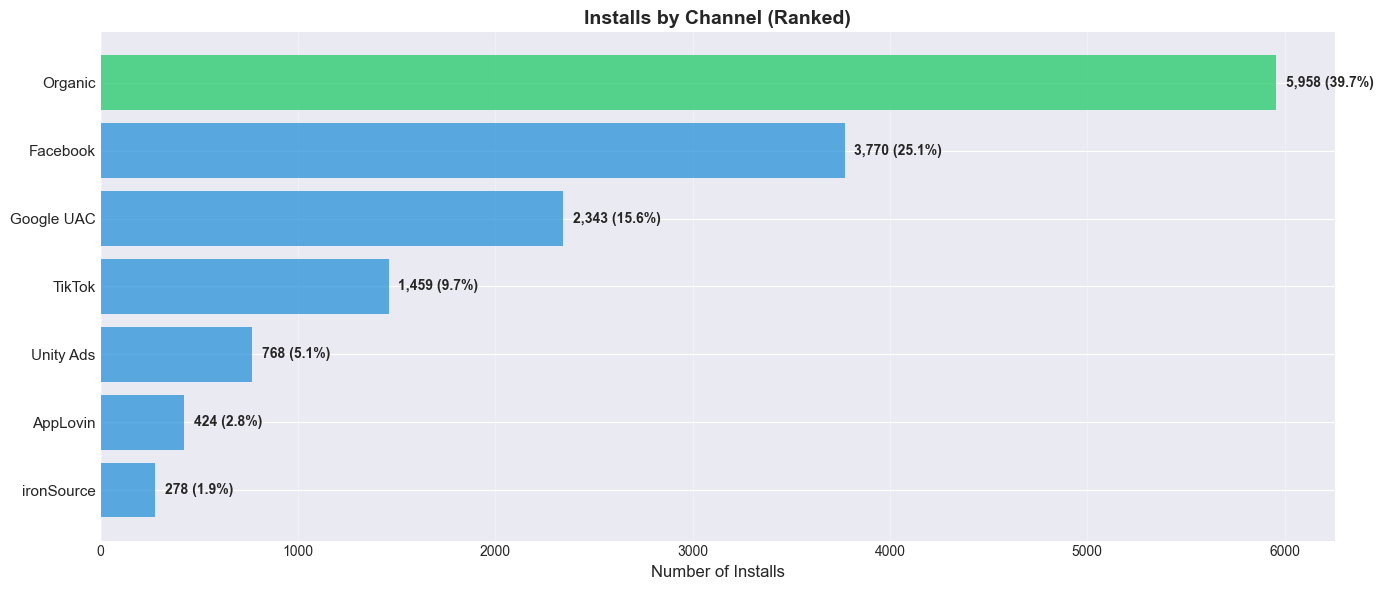

In [72]:
# График 3: Bar chart установок по каналам
fig, ax = plt.subplots(figsize=(14, 6))

channels_sorted = installs_by_channel.sort_values(ascending=True)
colors = ['#2ecc71' if ch == 'Organic' else '#3498db' for ch in channels_sorted.index]

bars = ax.barh(range(len(channels_sorted)), channels_sorted.values, color=colors, alpha=0.8)

# Добавляем значения на барах
for i, (channel, value) in enumerate(zip(channels_sorted.index, channels_sorted.values)):
    percentage = (value / total_installs) * 100
    ax.text(value + 50, i, f'{value:,} ({percentage:.1f}%)', 
            va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(channels_sorted)))
ax.set_yticklabels(channels_sorted.index, fontsize=11)
ax.set_xlabel('Number of Installs', fontsize=12)
ax.set_title('Installs by Channel (Ranked)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


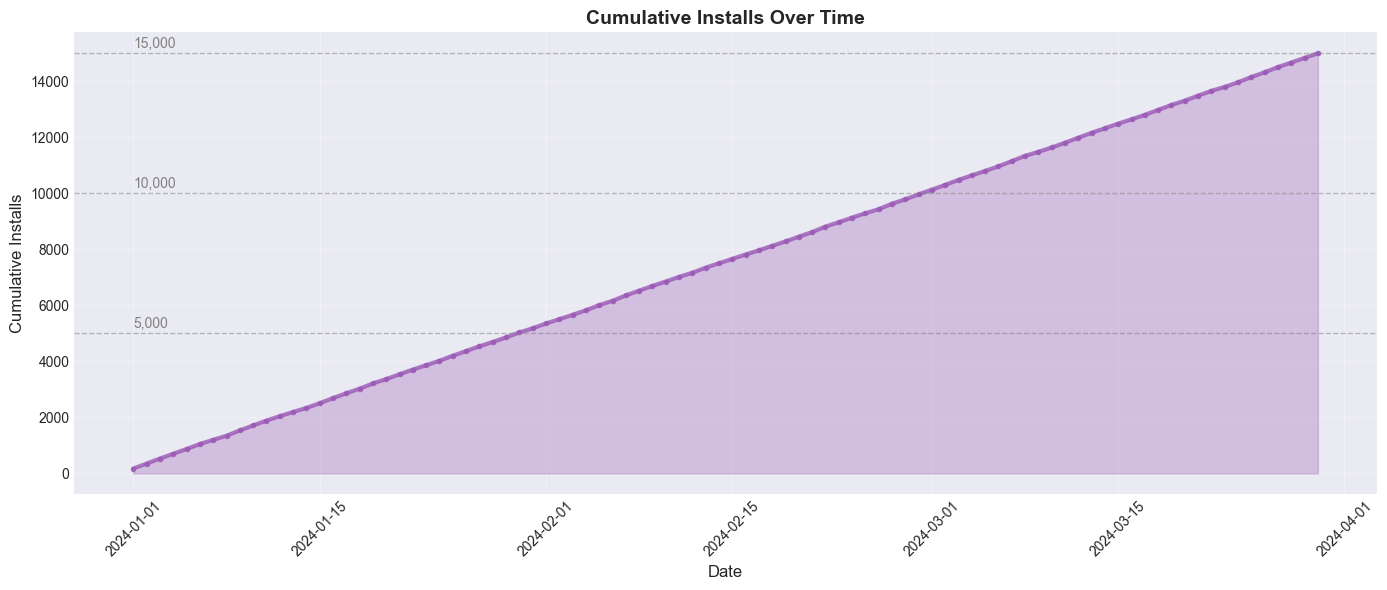

In [73]:
# График 4: Cumulative installs
daily_installs_cum = users_df.groupby('install_date').size().cumsum().reset_index(name='cumulative_installs')
daily_installs_cum['date'] = daily_installs_cum['install_date']

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_installs_cum['date'], daily_installs_cum['cumulative_installs'], 
        linewidth=3, color='#9b59b6', marker='o', markersize=3, alpha=0.8)
ax.fill_between(daily_installs_cum['date'], 0, daily_installs_cum['cumulative_installs'], 
                alpha=0.3, color='#9b59b6')

# Добавляем важные milestone
milestones = [5000, 10000, 15000]
for milestone in milestones:
    if milestone <= daily_installs_cum['cumulative_installs'].max():
        date_reached = daily_installs_cum[daily_installs_cum['cumulative_installs'] >= milestone].iloc[0]['date']
        ax.axhline(y=milestone, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.text(daily_installs_cum['date'].min(), milestone + 200, f'{milestone:,}', 
                fontsize=10, color='gray')

ax.set_title('Cumulative Installs Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Installs', fontsize=12)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">2. CPI (Cost Per Install)</h2>
</div>

### 📍 Определение

**CPI (Cost Per Install)** — средняя стоимость привлечения одной установки через платные каналы.

### 📍 Формула расчета

$$
\text{CPI} = \frac{\text{Total Ad Spend}}{\text{Number of Installs}}
$$

Можно рассчитывать:
- **Overall CPI** — по всем каналам
- **Channel CPI** — по конкретному каналу
- **Campaign CPI** — по конкретной кампании
- **Creative CPI** — по конкретному креативу

### 📍 Зачем нужна метрика

CPI — **ключевая метрика экономики UA**, которая:

1. **Показывает эффективность маркетинга**
   - Насколько дорого стоит привлечь пользователя
   - Какие каналы/креативы дешевле

2. **Используется для оптимизации бюджета**
   - Перераспределение между каналами
   - Решения о масштабировании

3. **Сравнивается с LTV для оценки прибыльности**
   - LTV > CPI × 3 считается здоровым
   - LTV < CPI = убыточное привлечение

4. **Бенчмарк для индустрии**
   - Сравнение с конкурентами
   - Оценка рыночных условий

### 📍 Что показывает

- **Низкий CPI (<$1.00)** — эффективное привлечение, hypercasual модель
- **Средний CPI ($1.00-$5.00)** — типично для casual/mid-core игр
- **Высокий CPI (>$5.00)** — премиум игры, конкурентные ниши
- **Растущий CPI** — усиление конкуренции, неэффективные креативы
- **Падающий CPI** — улучшение эффективности, новые аудитории

### 📍 На что влияет

✅ **Payback Period** — чем выше CPI, тем дольше окупаемость

✅ **ROI/ROAS** — влияет на итоговую прибыльность

✅ **LTV/CAC Ratio** — определяет unit economics

✅ **Масштабируемость** — низкий CPI позволяет масштабироваться

### 📍 Что на нее влияет

✅ **Положительные факторы (снижают CPI):**
- Высокий IPM/CTR (цепляющие креативы)
- Хороший таргетинг
- Оптимизированные кампании
- Lookalike audiences
- Ретаргетинг
- Seasonality (низкая конкуренция)
- Новые рекламные форматы

❌ **Негативные факторы (повышают CPI):**
- Низкий CVR в воронке
- Плохие креативы
- Широкий/неточный таргетинг
- Усталость аудитории (ad fatigue)
- Высокая конкуренция
- Праздничные сезоны (высокий спрос на рекламу)
- iOS 14.5+ (ограничения трекинга)

### 📍 Бенчмарки по жанрам

**iOS (2024):**

| Жанр | Хороший CPI | Средний CPI | Высокий CPI |
|------|-------------|-------------|-------------|
| **Hypercasual** | $0.30-0.80 | $0.80-1.50 | $1.50-3.00 |
| **Casual** | $1.00-2.00 | $2.00-4.00 | $4.00-7.00 |
| **Mid-core** | $2.00-4.00 | $4.00-7.00 | $7.00-12.00 |
| **Strategy** | $2.50-5.00 | $5.00-8.00 | $8.00-15.00 |
| **RTS** | $3.00-6.00 | $6.00-10.00 | $10.00-20.00 |
| **RPG** | $3.00-6.00 | $6.00-10.00 | $10.00-18.00 |
| **Puzzle** | $1.50-3.00 | $3.00-5.00 | $5.00-9.00 |

**Android (обычно на 20-40% дешевле iOS)**

### 📍 Как улучшить (снизить CPI)

**Оптимизация креативов:**
1. A/B тестирование креативов
2. User-generated content (UGC)
3. Нативные форматы (playable ads)
4. Тестирование разных hooks (первые 3 секунды)
5. Короткие динамичные видео

**Оптимизация таргетинга:**
1. Lookalike аудитории на paying users
2. Исключение low-quality audiences
3. Geo-оптимизация (tier-2/tier-3 страны)
4. Demographic refinement

**Оптимизация каналов:**
1. Диверсификация (не зависеть от одного канала)
2. Тестирование новых каналов
3. Bid optimization
4. Время показа (time of day optimization)

**Техническая оптимизация:**
1. Улучшение store listing (лучший CVR)
2. Pre-registration campaigns
3. Уменьшение размера APK/IPA
4. Оптимизация onboarding (снизить churn до установки)


### 📍 Важно: Уровни гранулярности CPI

**CPI — это не один скаляр!** CPI существует на разных уровнях агрегации:

#### **Уровень 1: User-level CPI (самый детальный)**
```
Каждый платный пользователь имеет свой CPI
user_00001: $2.35
user_00002: $2.67  
user_00003: $2.41
...
→ Распределение из 9,000+ точек данных
```

**Откуда берется вариация?**
- ✅ Разные аукционы (real-time bidding)
- ✅ Время показа (день/ночь, будни/выходные)
- ✅ Creative performance (один креатив дешевле другого)
- ✅ Audience segments (lookalike 1% vs 5%)
- ✅ Competition fluctuations
- ✅ Geographic location
- ✅ Device type (iOS дороже Android)

#### **Уровень 2: Campaign/Creative-level CPI**
```
Facebook_Creative_A: avg $2.30 (±$0.28)
Facebook_Creative_B: avg $2.70 (±$0.31)
TikTok_Creative_C: avg $2.85 (±$0.35)
→ Агрегация по кампаниям/креативам
```

#### **Уровень 3: Channel-level CPI**
```
Facebook: avg $2.50 (±$0.29)
Google UAC: avg $3.20 (±$0.36)
TikTok: avg $2.79 (±$0.32)
→ Агрегация по каналам
```

#### **Уровень 4: Overall CPI (самый агрегированный)**
```
Overall CPI: $2.60
→ Один скаляр для всей UA стратегии
```

**В нашем анализе:**
- **Расчеты** — работаем на всех уровнях
- **Распределения/Box plots** — показываем user-level CPI (самый детальный)
- **Средние/Агрегаты** — показываем channel/creative level
- **Перцентили** — рассчитываются на user-level (самая детальная гранулярность)


### 📍 Расчет на Python


### 📍 Детальный пример: Как Level 1 агрегируется в Level 3

Давайте посмотрим на конкретный пример агрегации для одного канала:


In [74]:
# ============================================================================
# НАГЛЯДНЫЙ ПРИМЕР: Как Level 1 (user-level) агрегируется в Level 3 (channel)
# ============================================================================

print("="*80)
print("ПРИМЕР АГРЕГАЦИИ: От User-Level к Channel-Level")
print("="*80)

# Возьмем один канал для примера (Facebook)
facebook_users = paid_users[paid_users['channel'] == 'Facebook'].copy()

print(f"\n📍 Level 1 (User-level): Facebook users")
print(f"   Количество строк (users): {len(facebook_users):,}")
print(f"   Каждая строка = 1 пользователь с индивидуальным CPI")
print(f"\n   Пример первых 10 users:")
print(facebook_users[['user_id', 'cpi']].head(10).to_string(index=False))

print(f"\n   Это массив из {len(facebook_users):,} индивидуальных CPI значений:")
print(f"   [${facebook_users.iloc[0]['cpi']:.2f}, ${facebook_users.iloc[1]['cpi']:.2f}, "
      f"${facebook_users.iloc[2]['cpi']:.2f}, ..., ${facebook_users.iloc[-1]['cpi']:.2f}]")

print(f"\n" + "="*80)
print(f"📍 Агрегация (groupby + agg):")
print(f"   Для ВСЕХ {len(facebook_users):,} users считаем статистики:")
print("="*80)

# Рассчитываем все статистики вручную для наглядности
fb_sum = facebook_users['cpi'].sum()
fb_count = len(facebook_users)
fb_mean = facebook_users['cpi'].mean()
fb_std = facebook_users['cpi'].std()
fb_min = facebook_users['cpi'].min()
fb_max = facebook_users['cpi'].max()
fb_median = facebook_users['cpi'].median()
fb_q25 = facebook_users['cpi'].quantile(0.25)
fb_q75 = facebook_users['cpi'].quantile(0.75)

print(f"\n   ✓ sum():     Σ всех {fb_count:,} CPI = ${fb_sum:,.2f}")
print(f"   ✓ count():   Количество users = {fb_count:,}")
print(f"   ✓ mean():    ${fb_sum:,.2f} / {fb_count:,} = ${fb_mean:.2f}  ← СРЕДНЕЕ")
print(f"   ✓ std():     Стандартное отклонение = ${fb_std:.2f}  ← ВАРИАБЕЛЬНОСТЬ")
print(f"   ✓ min():     Самый дешевый user = ${fb_min:.2f}")
print(f"   ✓ max():     Самый дорогой user = ${fb_max:.2f}")
print(f"   ✓ median():  50% users дешевле = ${fb_median:.2f}")
print(f"   ✓ 25th %ile: 25% users дешевле = ${fb_q25:.2f}")
print(f"   ✓ 75th %ile: 75% users дешевле = ${fb_q75:.2f}")

print(f"\n" + "="*80)
print(f"📍 Level 3 (Channel-level): Результат агрегации")
print(f"   Количество строк: 1 (один канал)")
print("="*80)
print(f"\n   Facebook:")
print(f"     Total Spend:  ${fb_sum:,.2f}")
print(f"     Installs:     {fb_count:,}")
print(f"     Avg CPI:      ${fb_mean:.2f}  ← Это СРЕДНЕЕ из {fb_count:,} user-level CPI")
print(f"     Std CPI:      ${fb_std:.2f}   ← Показывает разброс между users")
print(f"     Min CPI:      ${fb_min:.2f}")
print(f"     Max CPI:      ${fb_max:.2f}")

print(f"\n💡 КЛЮЧЕВОЙ МОМЕНТ:")
print(f"   Level 3 'Avg CPI' = mean() от {fb_count:,} индивидуальных user-level CPI")
print(f"   НЕ один скаляр, а агрегат из тысяч точек данных!")
print("="*80)


ПРИМЕР АГРЕГАЦИИ: От User-Level к Channel-Level

📍 Level 1 (User-level): Facebook users
   Количество строк (users): 3,770
   Каждая строка = 1 пользователь с индивидуальным CPI

   Пример первых 10 users:
   user_id  cpi
user_00001 2.06
user_00002 2.02
user_00007 2.20
user_00008 2.61
user_00010 2.10
user_00011 2.50
user_00013 2.03
user_00014 2.93
user_00018 2.80
user_00024 2.85

   Это массив из 3,770 индивидуальных CPI значений:
   [$2.06, $2.02, $2.20, ..., $2.52]

📍 Агрегация (groupby + agg):
   Для ВСЕХ 3,770 users считаем статистики:

   ✓ sum():     Σ всех 3,770 CPI = $9,428.08
   ✓ count():   Количество users = 3,770
   ✓ mean():    $9,428.08 / 3,770 = $2.50  ← СРЕДНЕЕ
   ✓ std():     Стандартное отклонение = $0.29  ← ВАРИАБЕЛЬНОСТЬ
   ✓ min():     Самый дешевый user = $2.00
   ✓ max():     Самый дорогой user = $3.00
   ✓ median():  50% users дешевле = $2.50
   ✓ 25th %ile: 25% users дешевле = $2.25
   ✓ 75th %ile: 75% users дешевле = $2.75

📍 Level 3 (Channel-level): Результат

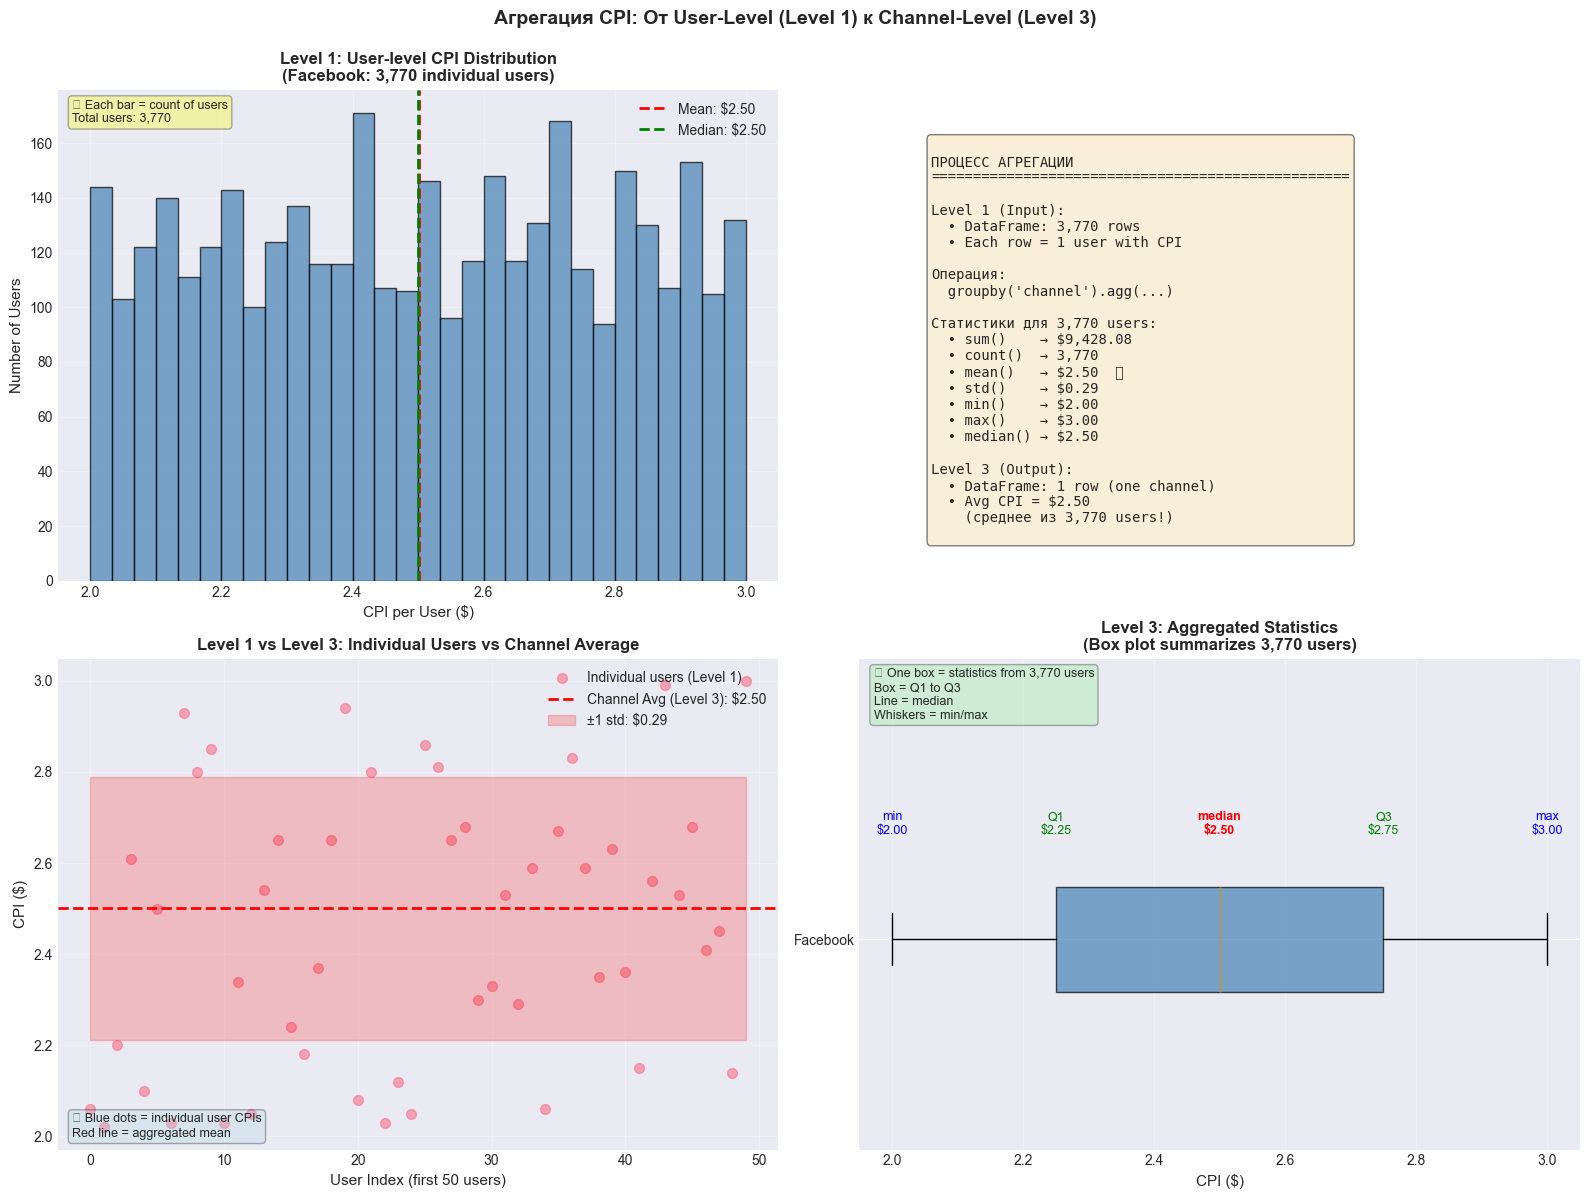


📊 ВИЗУАЛИЗАЦИЯ ПОКАЗЫВАЕТ:
  • Верхний левый: 3,770 индивидуальных user-level CPI (Level 1)
  • Верхний правый: Процесс агрегации (groupby + agg)
  • Нижний левый: Индивидуальные users vs агрегированное среднее
  • Нижний правый: Box plot как визуальное представление Level 3


In [75]:
# Визуализация процесса агрегации
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: User-level распределение для Facebook (Level 1)
ax1 = axes[0, 0]
ax1.hist(facebook_users['cpi'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(fb_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: ${fb_mean:.2f}')
ax1.axvline(fb_median, color='green', linestyle='--', linewidth=2, label=f'Median: ${fb_median:.2f}')
ax1.set_xlabel('CPI per User ($)', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title(f'Level 1: User-level CPI Distribution\n(Facebook: {fb_count:,} individual users)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, f'📊 Each bar = count of users\nTotal users: {fb_count:,}', 
         transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# График 2: Процесс агрегации (показываем статистики)
ax2 = axes[0, 1]
ax2.axis('off')
aggregation_text = f"""
ПРОЦЕСС АГРЕГАЦИИ
{'='*50}

Level 1 (Input):
  • DataFrame: {fb_count:,} rows
  • Each row = 1 user with CPI

Операция:
  groupby('channel').agg(...)
  
Статистики для {fb_count:,} users:
  • sum()    → ${fb_sum:,.2f}
  • count()  → {fb_count:,}
  • mean()   → ${fb_mean:.2f}  ⭐
  • std()    → ${fb_std:.2f}
  • min()    → ${fb_min:.2f}
  • max()    → ${fb_max:.2f}
  • median() → ${fb_median:.2f}
  
Level 3 (Output):
  • DataFrame: 1 row (one channel)
  • Avg CPI = ${fb_mean:.2f}
    (среднее из {fb_count:,} users!)
"""
ax2.text(0.1, 0.9, aggregation_text, fontsize=10, verticalalignment='top',
         family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# График 3: Сравнение Level 1 (sample) vs Level 3 (aggregated)
ax3 = axes[1, 0]
# Показываем первые 50 users
sample_users = facebook_users.head(50)
x = range(len(sample_users))
ax3.scatter(x, sample_users['cpi'], alpha=0.6, s=50, label='Individual users (Level 1)')
ax3.axhline(fb_mean, color='red', linestyle='--', linewidth=2, 
            label=f'Channel Avg (Level 3): ${fb_mean:.2f}')
ax3.fill_between(x, fb_mean - fb_std, fb_mean + fb_std, alpha=0.2, color='red',
                 label=f'±1 std: ${fb_std:.2f}')
ax3.set_xlabel('User Index (first 50 users)', fontsize=11)
ax3.set_ylabel('CPI ($)', fontsize=11)
ax3.set_title('Level 1 vs Level 3: Individual Users vs Channel Average', 
              fontsize=12, fontweight='bold')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.text(0.02, 0.02, f'📊 Blue dots = individual user CPIs\nRed line = aggregated mean', 
         transform=ax3.transAxes, fontsize=9, va='bottom',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# График 4: Box plot показывает агрегированные статистики
ax4 = axes[1, 1]
bp = ax4.boxplot([facebook_users['cpi']], 
                  labels=['Facebook'],
                  patch_artist=True,
                  showfliers=True,
                  vert=False)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)

# Аннотируем элементы box plot
ax4.text(fb_min, 1.15, f'min\n${fb_min:.2f}', ha='center', fontsize=9, color='blue')
ax4.text(fb_q25, 1.15, f'Q1\n${fb_q25:.2f}', ha='center', fontsize=9, color='green')
ax4.text(fb_median, 1.15, f'median\n${fb_median:.2f}', ha='center', fontsize=9, color='red', fontweight='bold')
ax4.text(fb_q75, 1.15, f'Q3\n${fb_q75:.2f}', ha='center', fontsize=9, color='green')
ax4.text(fb_max, 1.15, f'max\n${fb_max:.2f}', ha='center', fontsize=9, color='blue')

ax4.set_xlabel('CPI ($)', fontsize=11)
ax4.set_title(f'Level 3: Aggregated Statistics\n(Box plot summarizes {fb_count:,} users)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_ylim(0.7, 1.4)
ax4.text(0.02, 0.98, f'📊 One box = statistics from {fb_count:,} users\nBox = Q1 to Q3\nLine = median\nWhiskers = min/max', 
         transform=ax4.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.suptitle('Агрегация CPI: От User-Level (Level 1) к Channel-Level (Level 3)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 ВИЗУАЛИЗАЦИЯ ПОКАЗЫВАЕТ:")
print("="*80)
print(f"  • Верхний левый: {fb_count:,} индивидуальных user-level CPI (Level 1)")
print(f"  • Верхний правый: Процесс агрегации (groupby + agg)")
print(f"  • Нижний левый: Индивидуальные users vs агрегированное среднее")
print(f"  • Нижний правый: Box plot как визуальное представление Level 3")
print("="*80)


### 📍 Резюме: Агрегация по уровням

**Формула агрегации:**

```python
# Шаг 1: Level 1 → Level 3
channel_stats = paid_users.groupby('channel').agg({
    'cpi': ['mean', 'std', 'min', 'max', 'median', 'count', 'sum']
})

# Что происходит:
# 1. groupby('channel') - группируем users по каналам
# 2. agg(...) - для каждой группы (канала) применяем агрегирующие функции
#    к массиву user-level CPI:
#    - mean():   среднее арифметическое всех users
#    - std():    стандартное отклонение (разброс между users)
#    - min():    минимальный CPI среди users
#    - max():    максимальный CPI среди users
#    - median(): медиана (50-й перцентиль)
#    - count():  количество users
#    - sum():    сумма всех CPI (= total spend)
```

**Важно понимать:**
- ✅ **Level 3 "Avg CPI"** — это не один замер, а **mean() из тысяч user-level CPI**
- ✅ **Перцентили** всегда считаются на Level 1 (user-level)
- ✅ **Box plot** визуализирует распределение user-level данных
- ✅ **std (стандартное отклонение)** показывает вариабельность между users

**Аналогия:**
- Level 1 = экзаменационные баллы каждого студента в классе
- Level 3 = средний балл класса (но мы помним, что это среднее из индивидуальных баллов)


In [76]:
# ============================================================================
# ВАЖНО: CPI рассчитывается на разных уровнях агрегации!
# ============================================================================
# Уровень 1 (USER-LEVEL): paid_users['cpi'] - каждый user имеет свой CPI
#            Это самый детальный уровень (9,000+ точек данных)
# Уровень 2 (CREATIVE-LEVEL): агрегация по креативам
# Уровень 3 (CHANNEL-LEVEL): агрегация по каналам  
# Уровень 4 (OVERALL): один скаляр для всей стратегии
# ============================================================================

paid_users = users_df[users_df['channel'] != 'Organic'].copy()

# УРОВЕНЬ 4: Overall CPI (самый агрегированный - один скаляр)
total_spend = paid_users['cpi'].sum()  # Сумма всех user-level CPI
total_paid_installs = len(paid_users)
overall_cpi = total_spend / total_paid_installs if total_paid_installs > 0 else 0

print("=" * 70)
print("CPI (COST PER INSTALL) METRICS - MULTI-LEVEL ANALYSIS")
print("=" * 70)
print(f"Total Spend: ${total_spend:,.2f}")
print(f"Total Paid Installs: {total_paid_installs:,}")
print(f"Overall CPI (Level 4 - most aggregated): ${overall_cpi:.2f}")
print("=" * 70)

# УРОВЕНЬ 3: CPI по каналам (агрегация user-level CPI по каналам)
cpi_by_channel = paid_users.groupby('channel').agg({
    'cpi': ['sum', 'count', 'mean', 'std', 'min', 'max']
}).round(2)
cpi_by_channel.columns = ['Total Spend', 'Installs', 'Avg CPI', 'Std CPI', 'Min CPI', 'Max CPI']
cpi_by_channel = cpi_by_channel.sort_values('Avg CPI')

print("\nLevel 3 - CPI by Channel (aggregated from user-level):")
print(cpi_by_channel)

# УРОВЕНЬ 2: CPI по creative (агрегация user-level CPI по креативам)
cpi_by_creative = paid_users.groupby('creative').agg({
    'cpi': ['sum', 'count', 'mean', 'std']
}).round(2)
cpi_by_creative.columns = ['Total Spend', 'Installs', 'Avg CPI', 'Std CPI']
cpi_by_creative = cpi_by_creative.sort_values('Avg CPI')

print("\nLevel 2 - CPI by Creative (aggregated from user-level):")
print(cpi_by_creative)

# УРОВЕНЬ 1: User-level CPI статистика (самый детальный уровень)
print(f"\nLevel 1 - User-level CPI Statistics ({len(paid_users):,} data points):")
print(f"  Min CPI: ${paid_users['cpi'].min():.2f}  ← самый дешевый user")
print(f"  25th percentile: ${paid_users['cpi'].quantile(0.25):.2f}")
print(f"  Median CPI: ${paid_users['cpi'].median():.2f}  ← 50% users дешевле")
print(f"  Mean CPI: ${paid_users['cpi'].mean():.2f}")
print(f"  75th percentile: ${paid_users['cpi'].quantile(0.75):.2f}")
print(f"  Max CPI: ${paid_users['cpi'].max():.2f}  ← самый дорогой user")
print(f"  Std CPI: ${paid_users['cpi'].std():.2f}  ← вариабельность между users")

print(f"\n💡 Insight: CPI варьируется от ${paid_users['cpi'].min():.2f} до ${paid_users['cpi'].max():.2f}")
print(f"   Это {(paid_users['cpi'].max() / paid_users['cpi'].min()):.1f}x разница между самым дешевым и дорогим user!")


CPI (COST PER INSTALL) METRICS - MULTI-LEVEL ANALYSIS
Total Spend: $23,502.89
Total Paid Installs: 9,042
Overall CPI (Level 4 - most aggregated): $2.60

Level 3 - CPI by Channel (aggregated from user-level):
            Total Spend  Installs  Avg CPI  Std CPI  Min CPI  Max CPI
channel                                                              
ironSource       416.88       278     1.50     0.17     1.20     1.79
AppLovin         679.52       424     1.60     0.19     1.28     1.92
Unity Ads       1393.09       768     1.81     0.21     1.44     2.16
Facebook        9428.08      3770     2.50     0.29     2.00     3.00
TikTok          4076.68      1459     2.79     0.32     2.24     3.36
Google UAC      7508.64      2343     3.20     0.36     2.56     3.84

Level 2 - CPI by Creative (aggregated from user-level):
            Total Spend  Installs  Avg CPI  Std CPI
creative                                           
Creative_C      5899.25      2277     2.59     0.58
Creative_A      593

### 📍 Визуализация


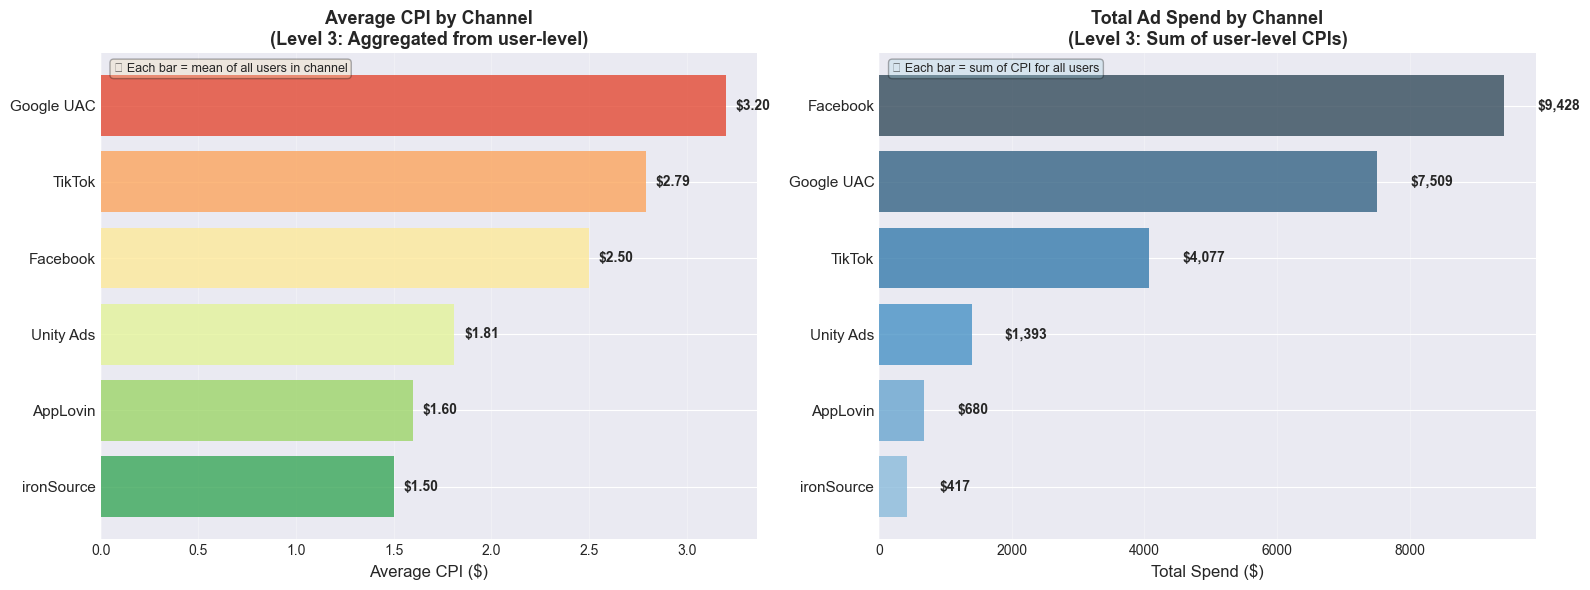

In [77]:
# График 1: CPI по каналам (bar chart + scatter)
# УРОВЕНЬ 3: Channel-level aggregation (средние из user-level CPI)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Средний CPI по каналам (Level 3)
ax1 = axes[0]
channels_cpi = cpi_by_channel.sort_values('Avg CPI', ascending=True)
colors = sns.color_palette('RdYlGn_r', len(channels_cpi))
bars = ax1.barh(range(len(channels_cpi)), channels_cpi['Avg CPI'], color=colors, alpha=0.8)

for i, value in enumerate(channels_cpi['Avg CPI']):
    ax1.text(value + 0.05, i, f'${value:.2f}', va='center', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(channels_cpi)))
ax1.set_yticklabels(channels_cpi.index, fontsize=11)
ax1.set_xlabel('Average CPI ($)', fontsize=12)
ax1.set_title('Average CPI by Channel\n(Level 3: Aggregated from user-level)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
# Добавляем текстовую подпись
ax1.text(0.02, 0.98, '📊 Each bar = mean of all users in channel', 
         transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Total Spend по каналам (Level 3)
ax2 = axes[1]
channels_spend = cpi_by_channel.sort_values('Total Spend', ascending=True)
colors2 = sns.color_palette('Blues_d', len(channels_spend))
bars2 = ax2.barh(range(len(channels_spend)), channels_spend['Total Spend'], color=colors2, alpha=0.8)

for i, value in enumerate(channels_spend['Total Spend']):
    ax2.text(value + 500, i, f'${value:,.0f}', va='center', fontsize=10, fontweight='bold')

ax2.set_yticks(range(len(channels_spend)))
ax2.set_yticklabels(channels_spend.index, fontsize=11)
ax2.set_xlabel('Total Spend ($)', fontsize=12)
ax2.set_title('Total Ad Spend by Channel\n(Level 3: Sum of user-level CPIs)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
# Добавляем текстовую подпись
ax2.text(0.02, 0.98, '📊 Each bar = sum of CPI for all users', 
         transform=ax2.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()


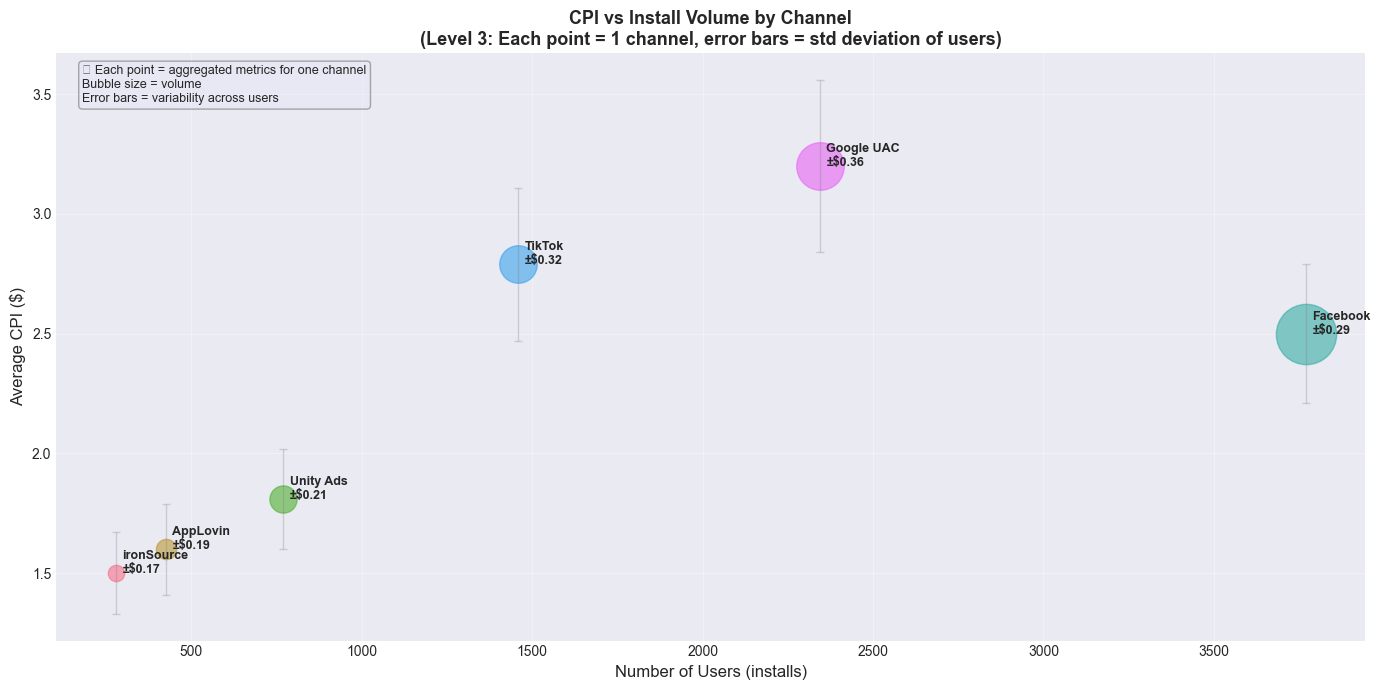

In [78]:
# График 2: Scatter plot - CPI vs Volume (installs)
# УРОВЕНЬ 3: Channel-level aggregation (каждая точка = 1 канал)
fig, ax = plt.subplots(figsize=(14, 7))

for channel in cpi_by_channel.index:
    installs = cpi_by_channel.loc[channel, 'Installs']
    avg_cpi = cpi_by_channel.loc[channel, 'Avg CPI']
    std_cpi = cpi_by_channel.loc[channel, 'Std CPI']
    
    # Scatter с размером пузыря = volume
    ax.scatter(installs, avg_cpi, s=installs*0.5, alpha=0.6, label=channel)
    
    # Добавляем error bars для показа вариабельности
    ax.errorbar(installs, avg_cpi, yerr=std_cpi, fmt='none', 
                color='gray', alpha=0.3, capsize=3, linewidth=1)
    
    ax.text(installs + 20, avg_cpi, f'{channel}\n±${std_cpi:.2f}', 
            fontsize=9, fontweight='bold')

ax.set_xlabel('Number of Users (installs)', fontsize=12)
ax.set_ylabel('Average CPI ($)', fontsize=12)
ax.set_title('CPI vs Install Volume by Channel\n(Level 3: Each point = 1 channel, error bars = std deviation of users)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Добавляем текстовую подпись
ax.text(0.02, 0.98, '📊 Each point = aggregated metrics for one channel\nBubble size = volume\nError bars = variability across users', 
        transform=ax.transAxes, fontsize=9, va='top',
        bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.3))

plt.tight_layout()
plt.show()


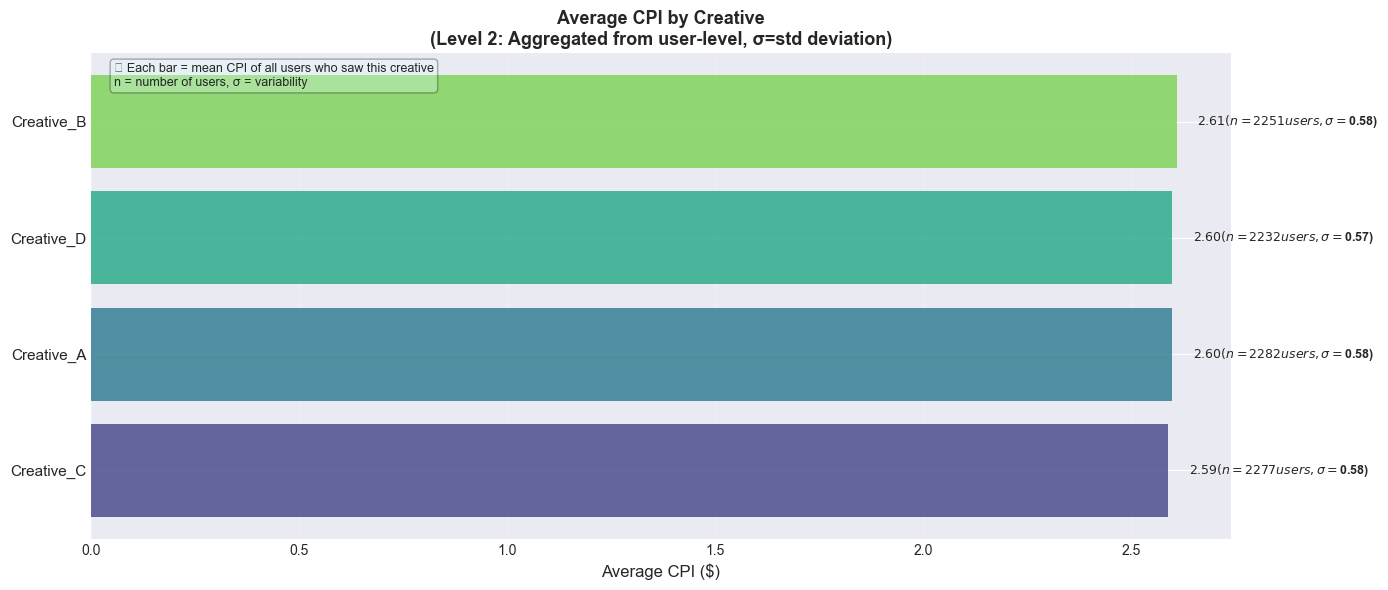

In [79]:
# График 3: CPI по creative
# УРОВЕНЬ 2: Creative-level aggregation (средние из user-level CPI)
fig, ax = plt.subplots(figsize=(14, 6))

creative_sorted = cpi_by_creative.sort_values('Avg CPI', ascending=True)
colors = sns.color_palette('viridis', len(creative_sorted))
bars = ax.barh(range(len(creative_sorted)), creative_sorted['Avg CPI'], color=colors, alpha=0.8)

for i, (creative, row) in enumerate(creative_sorted.iterrows()):
    ax.text(row['Avg CPI'] + 0.05, i, 
            f"${row['Avg CPI']:.2f} (n={int(row['Installs'])} users, σ=${row['Std CPI']:.2f})",
            va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(creative_sorted)))
ax.set_yticklabels(creative_sorted.index, fontsize=11)
ax.set_xlabel('Average CPI ($)', fontsize=12)
ax.set_title('Average CPI by Creative\n(Level 2: Aggregated from user-level, σ=std deviation)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Добавляем текстовую подпись
ax.text(0.02, 0.98, '📊 Each bar = mean CPI of all users who saw this creative\nn = number of users, σ = variability', 
        transform=ax.transAxes, fontsize=9, va='top',
        bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.3))

plt.tight_layout()
plt.show()


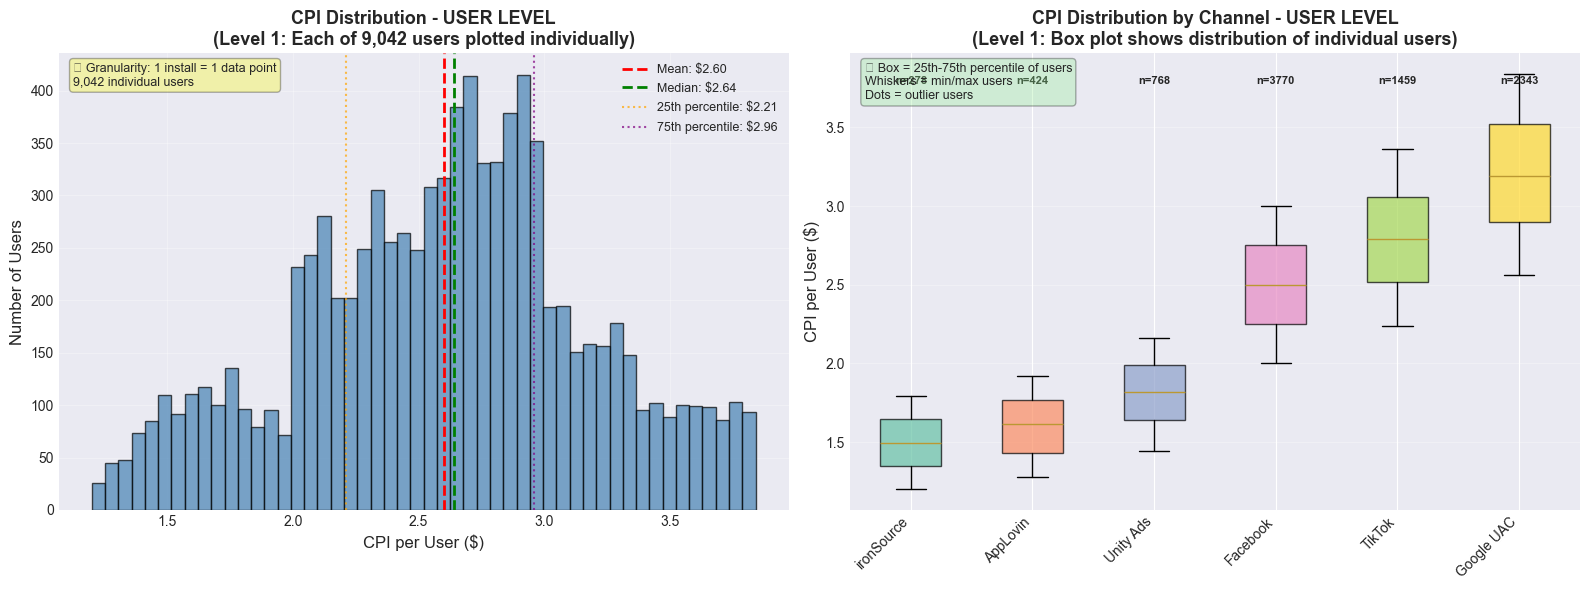


💡 ВАЖНО: Эти графики показывают USER-LEVEL распределение CPI!
• Histogram: каждый bin содержит индивидуальных users (не агрегаты)
• Box plot: показывает распределение CPI между 9,042 users
• Percentiles рассчитаны на уровне каждого individual install
• Это самый детальный уровень гранулярности (Level 1)


In [80]:
# График 4: CPI distribution (histogram + box plot)
# УРОВЕНЬ 1: User-level CPI (самый детальный - каждая точка = 1 install)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram всех CPI (Level 1: каждый bin содержит индивидуальных users)
ax1 = axes[0]
n, bins, patches = ax1.hist(paid_users['cpi'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(paid_users['cpi'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${paid_users["cpi"].mean():.2f}')
ax1.axvline(paid_users['cpi'].median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: ${paid_users["cpi"].median():.2f}')
ax1.axvline(paid_users['cpi'].quantile(0.25), color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'25th percentile: ${paid_users["cpi"].quantile(0.25):.2f}')
ax1.axvline(paid_users['cpi'].quantile(0.75), color='purple', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'75th percentile: ${paid_users["cpi"].quantile(0.75):.2f}')

ax1.set_xlabel('CPI per User ($)', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title(f'CPI Distribution - USER LEVEL\n(Level 1: Each of {len(paid_users):,} users plotted individually)', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую подпись
ax1.text(0.02, 0.98, f'📊 Granularity: 1 install = 1 data point\n{len(paid_users):,} individual users', 
         transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Box plot по каналам (Level 1: каждый point = individual user)
ax2 = axes[1]
channel_cpi_data = [paid_users[paid_users['channel'] == ch]['cpi'].values 
                    for ch in cpi_by_channel.index]
bp = ax2.boxplot(channel_cpi_data, labels=cpi_by_channel.index, patch_artist=True,
                 showfliers=True)  # Показываем outliers

for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(cpi_by_channel))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Добавляем количество users на каждом канале
for i, ch in enumerate(cpi_by_channel.index):
    n_users = len(paid_users[paid_users['channel'] == ch])
    ax2.text(i+1, ax2.get_ylim()[1]*0.95, f'n={n_users}', 
             ha='center', fontsize=8, fontweight='bold')

ax2.set_ylabel('CPI per User ($)', fontsize=12)
ax2.set_title('CPI Distribution by Channel - USER LEVEL\n(Level 1: Box plot shows distribution of individual users)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Добавляем текстовую подпись
ax2.text(0.02, 0.98, '📊 Box = 25th-75th percentile of users\nWhiskers = min/max users\nDots = outlier users', 
         transform=ax2.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 ВАЖНО: Эти графики показывают USER-LEVEL распределение CPI!")
print("="*70)
print(f"• Histogram: каждый bin содержит индивидуальных users (не агрегаты)")
print(f"• Box plot: показывает распределение CPI между {len(paid_users):,} users")
print(f"• Percentiles рассчитаны на уровне каждого individual install")
print(f"• Это самый детальный уровень гранулярности (Level 1)")
print("="*70)


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">3. IPM (Install Per Mille) & CTR (Click-Through Rate)</h2>
</div>

### 📍 Определение

**IPM (Install Per Mille)** — количество установок на 1000 показов рекламы.

**CTR (Click-Through Rate)** — процент пользователей, которые кликнули на рекламу от общего числа показов.

### 📍 Формула расчета

$$
\text{IPM} = \frac{\text{Installs}}{\text{Impressions}} \times 1000
$$

$$
\text{CTR} = \frac{\text{Clicks}}{\text{Impressions}} \times 100\%
$$

$$
\text{CVR (Conversion Rate)} = \frac{\text{Installs}}{\text{Clicks}} \times 100\%
$$

Связь метрик:
$$
\text{IPM} = \text{CTR} \times \text{CVR} \times 10
$$

### 📍 Зачем нужна метрика

IPM и CTR — **метрики эффективности креативов**, которые:

1. **Показывают качество креативов**
   - Насколько привлекательна реклама
   - Соответствие ожиданиям аудитории

2. **Влияют на CPI**
   - Высокий IPM = низкий CPI
   - Высокий CTR = больше кликов = больше установок

3. **Используются для оптимизации**
   - A/B тестирование креативов
   - Выбор лучших форматов

4. **Ранний индикатор эффективности**
   - Можно оценить быстро (не нужно ждать установок)

### 📍 Что показывает

**IPM:**
- **Высокий IPM (>3-5)** — отличные креативы, сильный product-market fit
- **Средний IPM (1-3)** — нормальные креативы
- **Низкий IPM (<1)** — слабые креативы, несоответствие аудитории

**CTR:**
- **Высокий CTR (>5%)** — цепляющие креативы
- **Средний CTR (2-5%)** — стандартный уровень
- **Низкий CTR (<2%)** — неэффективные креативы

### 📍 На что влияет

✅ **CPI** — высокий IPM/CTR → низкий CPI

✅ **Масштабируемость** — с хорошим IPM можно масштабировать кампании

✅ **Quality of traffic** — высокий CTR может означать качественный трафик

### 📍 Что на нее влияет

✅ **Положительные факторы:**
- Качественные, цепляющие креативы
- Релевантность аудитории
- Сильный hook (первые 3 секунды)
- Playable ads (интерактивные)
- UGC (user-generated content)
- Четкий value proposition
- Тестирование различных форматов

❌ **Негативные факторы:**
- Плохое качество креативов
- Misleading ads (обман ожиданий)
- Generic креативы (неотличимые от конкурентов)
- Широкий таргетинг
- Ad fatigue (усталость от рекламы)
- Неправильный формат для платформы

### 📍 Бенчмарки по жанрам

| Жанр | Good IPM | Good CTR | Примечания |
|------|----------|----------|------------|
| **Hypercasual** | 4-8 | 3-6% | Высокая конверсия |
| **Casual** | 2-4 | 2-4% | Стандартный уровень |
| **Mid-core** | 1.5-3 | 2-4% | Нишевая аудитория |
| **Strategy** | 1-2.5 | 1.5-3% | Длинный цикл принятия решения |
| **RTS** | 1-2 | 1.5-3% | Требует понимания жанра |
| **RPG** | 1.5-3 | 2-4% | Зависит от IP |
| **Puzzle** | 3-6 | 2.5-5% | Широкая аудитория |

### 📍 Как улучшить

**Улучшение IPM/CTR:**
1. A/B тестирование креативов (минимум 4-6 вариантов)
2. Фокус на первые 3 секунды видео (hook)
3. Использование playable ads
4. UGC форматы (выглядят натурально)
5. Показ реального gameplay
6. Эмоциональные триггеры
7. Четкий CTA (call-to-action)
8. Адаптация под платформу (TikTok ≠ Facebook)
9. Тестирование разных форматов (video, static, carousel)
10. Seasonal креативы (праздники, события)


### 📍 Расчет на Python


In [81]:
# Расчет IPM, CTR, CVR по каналам из воронки
funnel_by_channel = funnel_aggregated.groupby('channel').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'installs': 'sum',
    'spend': 'sum'
}).reset_index()

# Рассчитываем метрики
funnel_by_channel['ctr'] = (funnel_by_channel['clicks'] / funnel_by_channel['impressions'] * 100).round(2)
funnel_by_channel['cvr'] = (funnel_by_channel['installs'] / funnel_by_channel['clicks'] * 100).round(2)
funnel_by_channel['ipm'] = (funnel_by_channel['installs'] / funnel_by_channel['impressions'] * 1000).round(2)
funnel_by_channel['cpi'] = (funnel_by_channel['spend'] / funnel_by_channel['installs']).round(2)

# Сортируем по IPM
funnel_by_channel_sorted = funnel_by_channel.sort_values('ipm', ascending=False)

print("=" * 90)
print("FUNNEL METRICS (IPM, CTR, CVR) BY CHANNEL")
print("=" * 90)
print(funnel_by_channel_sorted[['channel', 'impressions', 'clicks', 'installs', 'ctr', 'cvr', 'ipm', 'cpi']].to_string(index=False))
print("=" * 90)

# IPM, CTR по creative
funnel_by_creative = funnel_aggregated.groupby('creative').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'installs': 'sum',
    'spend': 'sum'
}).reset_index()

funnel_by_creative['ctr'] = (funnel_by_creative['clicks'] / funnel_by_creative['impressions'] * 100).round(2)
funnel_by_creative['cvr'] = (funnel_by_creative['installs'] / funnel_by_creative['clicks'] * 100).round(2)
funnel_by_creative['ipm'] = (funnel_by_creative['installs'] / funnel_by_creative['impressions'] * 1000).round(2)
funnel_by_creative = funnel_by_creative.sort_values('ipm', ascending=False)

print("\nFUNNEL METRICS BY CREATIVE:")
print(funnel_by_creative[['creative', 'impressions', 'clicks', 'installs', 'ctr', 'cvr', 'ipm']].to_string(index=False))

# Overall metrics
total_impressions = funnel_by_channel['impressions'].sum()
total_clicks = funnel_by_channel['clicks'].sum()
total_installs_paid = funnel_by_channel['installs'].sum()

overall_ctr = (total_clicks / total_impressions * 100)
overall_cvr = (total_installs_paid / total_clicks * 100)
overall_ipm = (total_installs_paid / total_impressions * 1000)

print(f"\nOverall Metrics:")
print(f"  Total Impressions: {total_impressions:,}")
print(f"  Total Clicks: {total_clicks:,}")
print(f"  Total Installs: {total_installs_paid:,}")
print(f"  Overall CTR: {overall_ctr:.2f}%")
print(f"  Overall CVR: {overall_cvr:.2f}%")
print(f"  Overall IPM: {overall_ipm:.2f}")


FUNNEL METRICS (IPM, CTR, CVR) BY CHANNEL
   channel  impressions  clicks  installs  ctr   cvr   ipm  cpi
  AppLovin        38893    1726       424 4.44 24.57 10.90 1.60
Google UAC       219146    9590      2343 4.38 24.43 10.69 3.20
ironSource        26191    1126       278 4.30 24.69 10.61 1.50
  Facebook       355708   15538      3770 4.37 24.26 10.60 2.50
    TikTok       138946    6006      1459 4.32 24.29 10.50 2.79
 Unity Ads        73460    3181       768 4.33 24.14 10.45 1.81

FUNNEL METRICS BY CREATIVE:
  creative  impressions  clicks  installs  ctr   cvr   ipm
Creative_A       212293    9395      2282 4.43 24.29 10.75
Creative_B       212431    9225      2251 4.34 24.40 10.60
Creative_C       214805    9377      2277 4.37 24.28 10.60
Creative_D       212815    9170      2232 4.31 24.34 10.49

Overall Metrics:
  Total Impressions: 852,344
  Total Clicks: 37,167
  Total Installs: 9,042
  Overall CTR: 4.36%
  Overall CVR: 24.33%
  Overall IPM: 10.61


### 📍 Визуализация


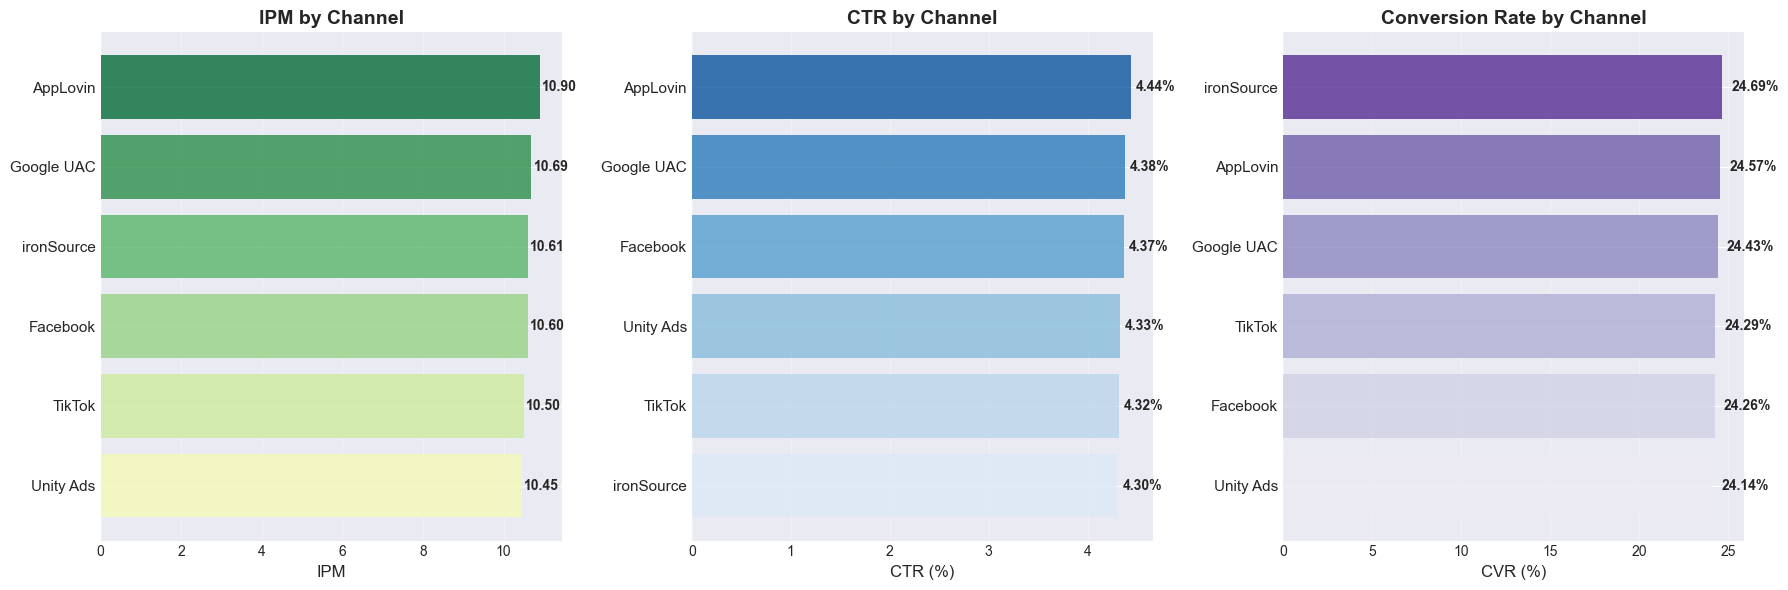

In [82]:
# График 1: IPM, CTR, CVR по каналам (bar chart)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# IPM
ax1 = axes[0]
ipm_sorted = funnel_by_channel_sorted.sort_values('ipm', ascending=True)
colors1 = sns.color_palette('YlGn', len(ipm_sorted))
bars1 = ax1.barh(range(len(ipm_sorted)), ipm_sorted['ipm'], color=colors1, alpha=0.8)
for i, value in enumerate(ipm_sorted['ipm']):
    ax1.text(value + 0.05, i, f'{value:.2f}', va='center', fontsize=10, fontweight='bold')
ax1.set_yticks(range(len(ipm_sorted)))
ax1.set_yticklabels(ipm_sorted['channel'], fontsize=11)
ax1.set_xlabel('IPM', fontsize=12)
ax1.set_title('IPM by Channel', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# CTR
ax2 = axes[1]
ctr_sorted = funnel_by_channel_sorted.sort_values('ctr', ascending=True)
colors2 = sns.color_palette('Blues', len(ctr_sorted))
bars2 = ax2.barh(range(len(ctr_sorted)), ctr_sorted['ctr'], color=colors2, alpha=0.8)
for i, value in enumerate(ctr_sorted['ctr']):
    ax2.text(value + 0.05, i, f'{value:.2f}%', va='center', fontsize=10, fontweight='bold')
ax2.set_yticks(range(len(ctr_sorted)))
ax2.set_yticklabels(ctr_sorted['channel'], fontsize=11)
ax2.set_xlabel('CTR (%)', fontsize=12)
ax2.set_title('CTR by Channel', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# CVR
ax3 = axes[2]
cvr_sorted = funnel_by_channel_sorted.sort_values('cvr', ascending=True)
colors3 = sns.color_palette('Purples', len(cvr_sorted))
bars3 = ax3.barh(range(len(cvr_sorted)), cvr_sorted['cvr'], color=colors3, alpha=0.8)
for i, value in enumerate(cvr_sorted['cvr']):
    ax3.text(value + 0.5, i, f'{value:.2f}%', va='center', fontsize=10, fontweight='bold')
ax3.set_yticks(range(len(cvr_sorted)))
ax3.set_yticklabels(cvr_sorted['channel'], fontsize=11)
ax3.set_xlabel('CVR (%)', fontsize=12)
ax3.set_title('Conversion Rate by Channel', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


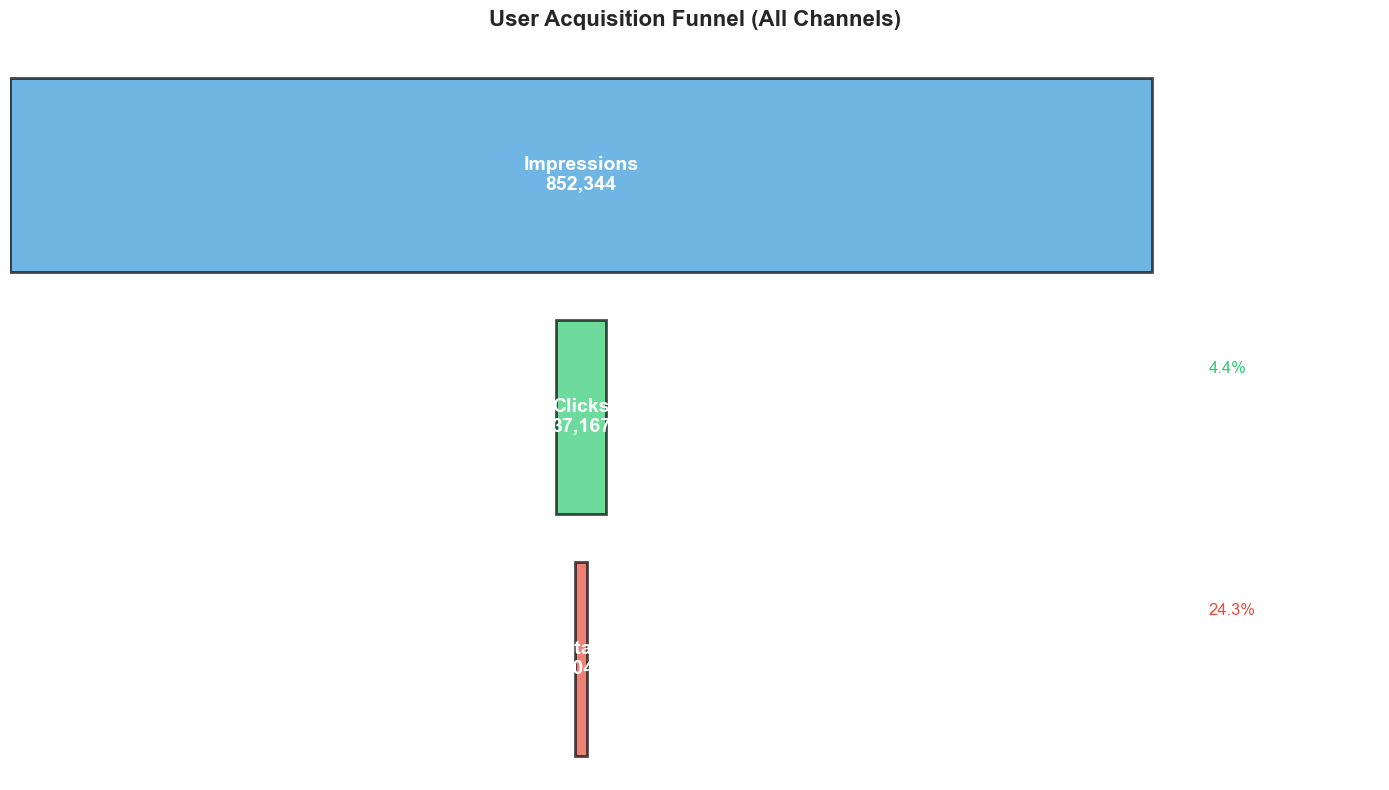

In [83]:
# График 2: Воронка конверсии (funnel)
fig, ax = plt.subplots(figsize=(14, 8))

# Данные для воронки
stages = ['Impressions', 'Clicks', 'Installs']
values = [total_impressions, total_clicks, total_installs_paid]
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Нормализуем для визуализации воронки
max_val = max(values)
normalized = [v / max_val for v in values]

# Рисуем воронку
for i, (stage, value, norm, color) in enumerate(zip(stages, values, normalized, colors)):
    # Трапеция для каждой ступени
    y_pos = len(stages) - i - 1
    width = norm
    
    # Создаем трапецию
    left = (1 - width) / 2
    right = left + width
    
    # Рисуем прямоугольник
    rect = plt.Rectangle((left, y_pos - 0.4), width, 0.8, 
                          facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax.add_patch(rect)
    
    # Добавляем текст
    ax.text(0.5, y_pos, f'{stage}\n{value:,}', 
            ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    
    # Добавляем процент конверсии
    if i > 0:
        conversion = (values[i] / values[i-1]) * 100
        ax.text(1.05, y_pos + 0.2, f'{conversion:.1f}%', 
                ha='left', va='center', fontsize=12, color=color)

ax.set_xlim(0, 1.2)
ax.set_ylim(-0.5, len(stages) - 0.5)
ax.axis('off')
ax.set_title('User Acquisition Funnel (All Channels)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


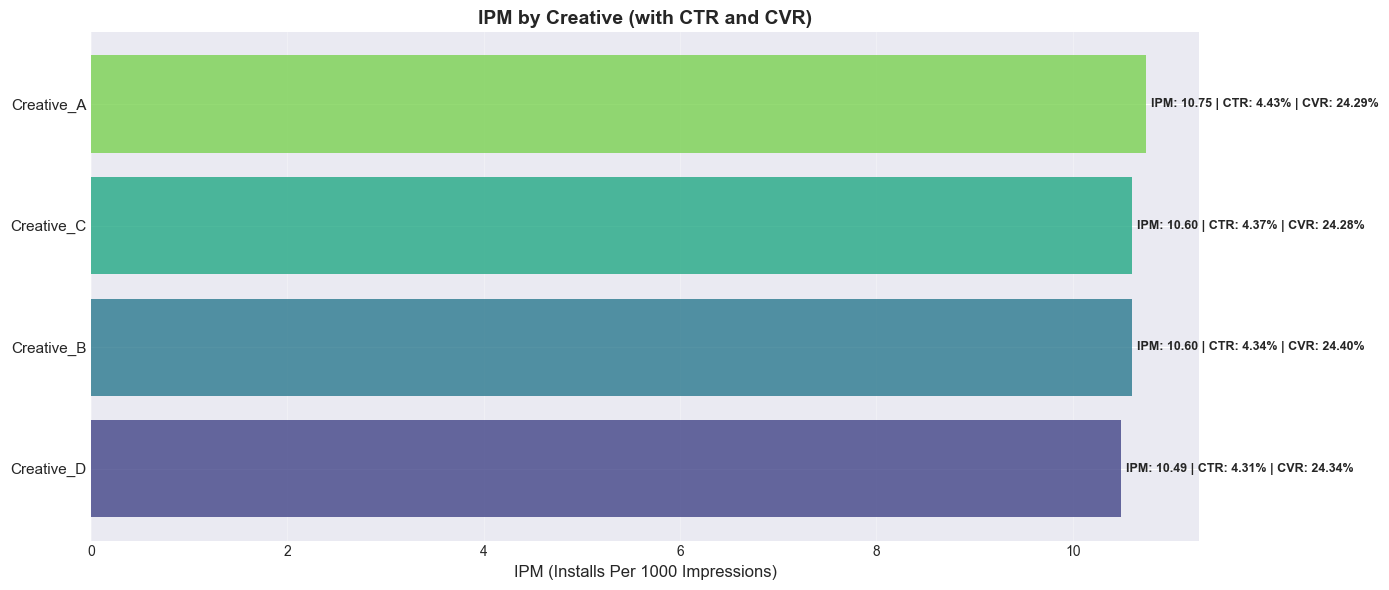

In [84]:
# График 3: IPM по creative (comparison)
fig, ax = plt.subplots(figsize=(14, 6))

creative_sorted = funnel_by_creative.sort_values('ipm', ascending=True)
colors = sns.color_palette('viridis', len(creative_sorted))
bars = ax.barh(range(len(creative_sorted)), creative_sorted['ipm'], color=colors, alpha=0.8)

for i, (creative, row) in enumerate(creative_sorted.iterrows()):
    ax.text(row['ipm'] + 0.05, i, 
            f"IPM: {row['ipm']:.2f} | CTR: {row['ctr']:.2f}% | CVR: {row['cvr']:.2f}%",
            va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(creative_sorted)))
ax.set_yticklabels(creative_sorted['creative'], fontsize=11)
ax.set_xlabel('IPM (Installs Per 1000 Impressions)', fontsize=12)
ax.set_title('IPM by Creative (with CTR and CVR)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


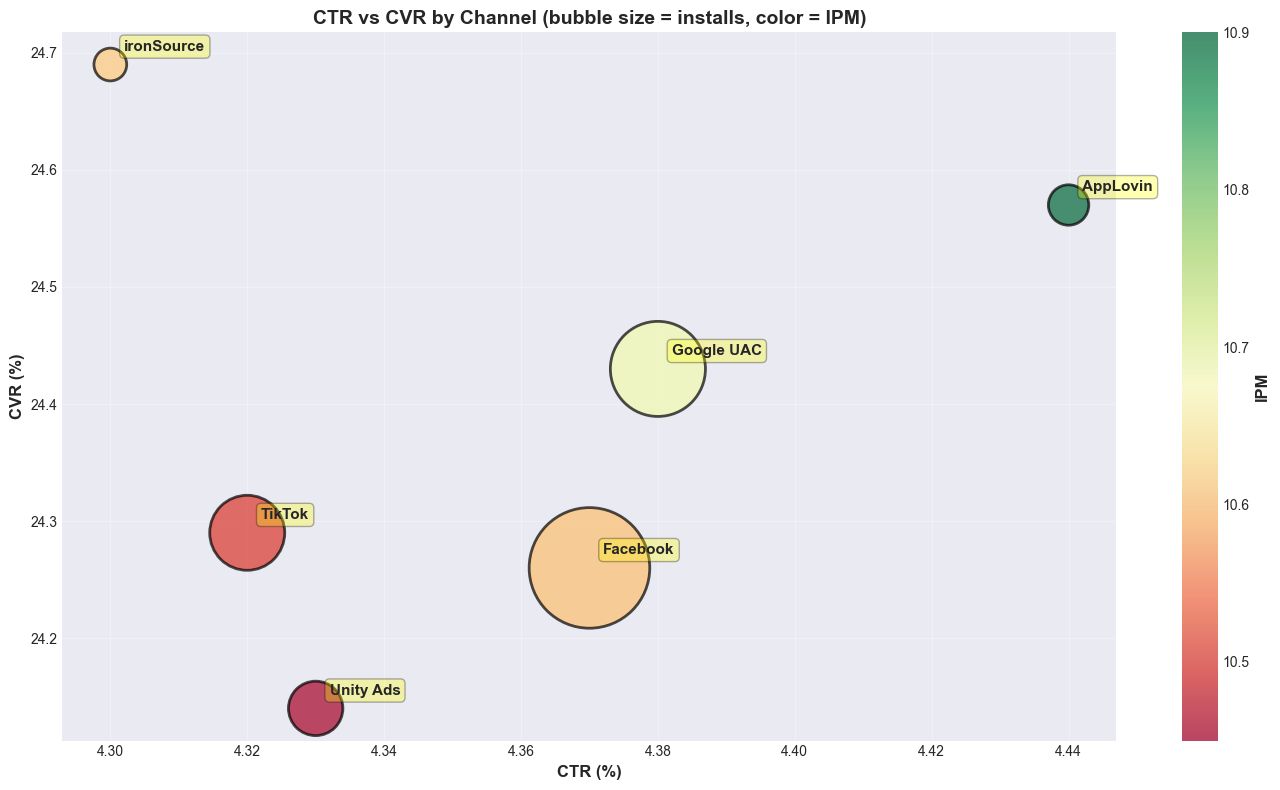

In [85]:
# График 4: Scatter plot - CTR vs CVR (colored by IPM)
fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(funnel_by_channel_sorted['ctr'], 
                     funnel_by_channel_sorted['cvr'],
                     s=funnel_by_channel_sorted['installs']*2,
                     c=funnel_by_channel_sorted['ipm'],
                     cmap='RdYlGn',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=2)

# Добавляем названия каналов
for idx, row in funnel_by_channel_sorted.iterrows():
    ax.annotate(row['channel'], 
                (row['ctr'], row['cvr']),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=11,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('IPM', fontsize=12, fontweight='bold')

ax.set_xlabel('CTR (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('CVR (%)', fontsize=12, fontweight='bold')
ax.set_title('CTR vs CVR by Channel (bubble size = installs, color = IPM)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">4. Organic vs Paid Installs (Детальное сравнение)</h2>
</div>

### 📍 Определение

**Organic Installs** — установки без прямых рекламных затрат (ASO, word-of-mouth, virality).

**Paid Installs** — установки через платные каналы привлечения.

### 📍 Формула расчета

$$
\text{Organic Rate} = \frac{\text{Organic Installs}}{\text{Total Installs}} \times 100\%
$$

$$
\text{Paid Rate} = \frac{\text{Paid Installs}}{\text{Total Installs}} \times 100\%
$$

### 📍 Зачем нужна метрика

Соотношение органики и платных установок показывает:

1. **Качество продукта** — высокая органика = хороший product-market fit
2. **Зависимость от UA** — высокая доля paid = риск при остановке кампаний  
3. **Экономика** — органика обычно имеет лучший LTV и retention
4. **Виральность** — органический рост указывает на сильный word-of-mouth

### 📍 Что показывает

**Органика:**
- ✅ Более высокий retention
- ✅ Более высокий LTV
- ✅ Лучший paying rate
- ✅ Нулевой CAC

**Paid:**
- ✅ Контролируемый рост
- ✅ Масштабируемость
- ❌ Зависимость от бюджета
- ❌ Обычно ниже retention

### 📍 На что влияет

✅ **Overall LTV/CAC** — больше органики → лучшая экономика

✅ **Sustainability** — высокая органика = устойчивый рост

✅ **Valuation** — инвесторы ценят высокую долю органики

### 📍 Что на нее влияет

✅ **Положительные факторы (увеличивают органику):**
- Сильный product-market fit
- Виральные механики
- Высокий retention
- Активное community
- Хорошее ASO
- Положительные отзывы
- Media coverage / PR

❌ **Негативные факторы:**
- Новый продукт (пока нет word-of-mouth)
- Низкий retention
- Слабое ASO
- Конкурентная ниша
- Отсутствие виральности

### 📍 Бенчмарки по жанрам

См. таблицу в секции "Installs"

### 📍 Как улучшить

**Увеличение органики:**
1. ASO optimization (keywords, visuals)
2. Виральные механики (invite friends, sharing)
3. Social features
4. PR и media outreach
5. Community building
6. High retention → больше рефералов
7. App Store featuring
8. Cross-promotion с другими продуктами


### 📍 Расчет на Python


In [86]:
# Детальное сравнение Organic vs Paid
organic_users = users_df[users_df['channel'] == 'Organic']
paid_users = users_df[users_df['channel'] != 'Organic']

# Базовые метрики
print("=" * 70)
print("ORGANIC VS PAID COMPARISON")
print("=" * 70)

comparison = pd.DataFrame({
    'Metric': ['Installs', 'Share %', 'D1 Retention %', 'D7 Retention %', 
               'Paying Rate %', 'Avg Revenue', 'Total Revenue'],
    'Organic': [
        len(organic_users),
        len(organic_users) / len(users_df) * 100,
        organic_users['d1_retained'].mean() * 100,
        organic_users['d7_retained'].mean() * 100,
        (organic_users['total_revenue'] > 0).mean() * 100,
        organic_users['total_revenue'].mean(),
        organic_users['total_revenue'].sum()
    ],
    'Paid': [
        len(paid_users),
        len(paid_users) / len(users_df) * 100,
        paid_users['d1_retained'].mean() * 100,
        paid_users['d7_retained'].mean() * 100,
        (paid_users['total_revenue'] > 0).mean() * 100,
        paid_users['total_revenue'].mean(),
        paid_users['total_revenue'].sum()
    ]
})

comparison['Organic'] = comparison['Organic'].round(2)
comparison['Paid'] = comparison['Paid'].round(2)
comparison['Difference %'] = ((comparison['Organic'] - comparison['Paid']) / comparison['Paid'] * 100).round(1)

print(comparison.to_string(index=False))
print("=" * 70)

print(f"\n📊 Key Insights:")
print(f"   • Organic has {comparison.loc[2, 'Difference %']:.1f}% {'better' if comparison.loc[2, 'Difference %'] > 0 else 'worse'} D1 retention")
print(f"   • Organic has {comparison.loc[3, 'Difference %']:.1f}% {'better' if comparison.loc[3, 'Difference %'] > 0 else 'worse'} D7 retention")
print(f"   • Organic has {comparison.loc[4, 'Difference %']:.1f}% {'better' if comparison.loc[4, 'Difference %'] > 0 else 'worse'} paying rate")
print(f"   • Organic users generate {comparison.loc[5, 'Difference %']:.1f}% {'more' if comparison.loc[5, 'Difference %'] > 0 else 'less'} revenue on average")


ORGANIC VS PAID COMPARISON
        Metric  Organic    Paid  Difference %
      Installs  5958.00 9042.00         -34.1
       Share %    39.72   60.28         -34.1
D1 Retention %    44.14   37.33          18.2
D7 Retention %    20.51   15.98          28.3
 Paying Rate %     5.25    3.85          36.4
   Avg Revenue     0.72    0.48          50.0
 Total Revenue  4279.03 4334.97          -1.3

📊 Key Insights:
   • Organic has 18.2% better D1 retention
   • Organic has 28.3% better D7 retention
   • Organic has 36.4% better paying rate
   • Organic users generate 50.0% more revenue on average


### 📍 Визуализация


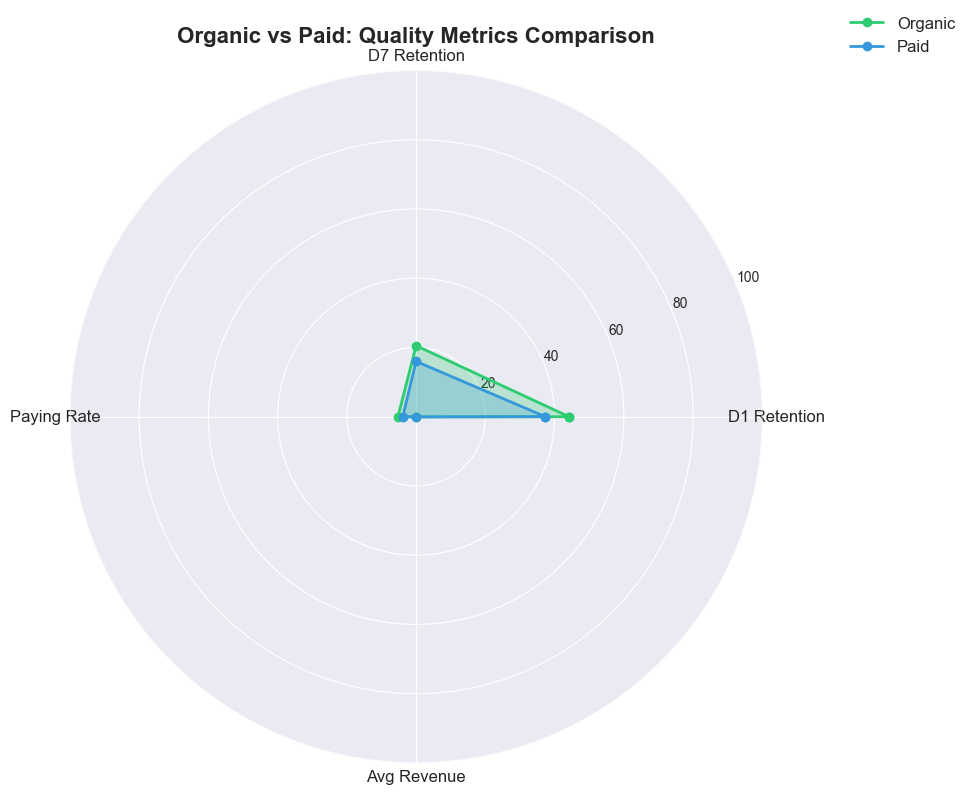

In [87]:
# График 1: Сравнение ключевых метрик (radar chart)
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Метрики для сравнения (нормализуем к 0-100)
categories = ['D1 Retention', 'D7 Retention', 'Paying Rate', 'Avg Revenue']
organic_values = [
    organic_users['d1_retained'].mean() * 100,
    organic_users['d7_retained'].mean() * 100,
    (organic_users['total_revenue'] > 0).mean() * 100,
    min(organic_users['total_revenue'].mean() / 10, 100)  # Normalize revenue
]
paid_values = [
    paid_users['d1_retained'].mean() * 100,
    paid_users['d7_retained'].mean() * 100,
    (paid_users['total_revenue'] > 0).mean() * 100,
    min(paid_users['total_revenue'].mean() / 10, 100)
]

# Количество переменных
num_vars = len(categories)

# Вычисляем угол для каждой оси
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
organic_values += organic_values[:1]
paid_values += paid_values[:1]
angles += angles[:1]

# Рисуем
ax.plot(angles, organic_values, 'o-', linewidth=2, label='Organic', color='#2ecc71')
ax.fill(angles, organic_values, alpha=0.25, color='#2ecc71')
ax.plot(angles, paid_values, 'o-', linewidth=2, label='Paid', color='#3498db')
ax.fill(angles, paid_values, alpha=0.25, color='#3498db')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 100)
ax.set_title('Organic vs Paid: Quality Metrics Comparison', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


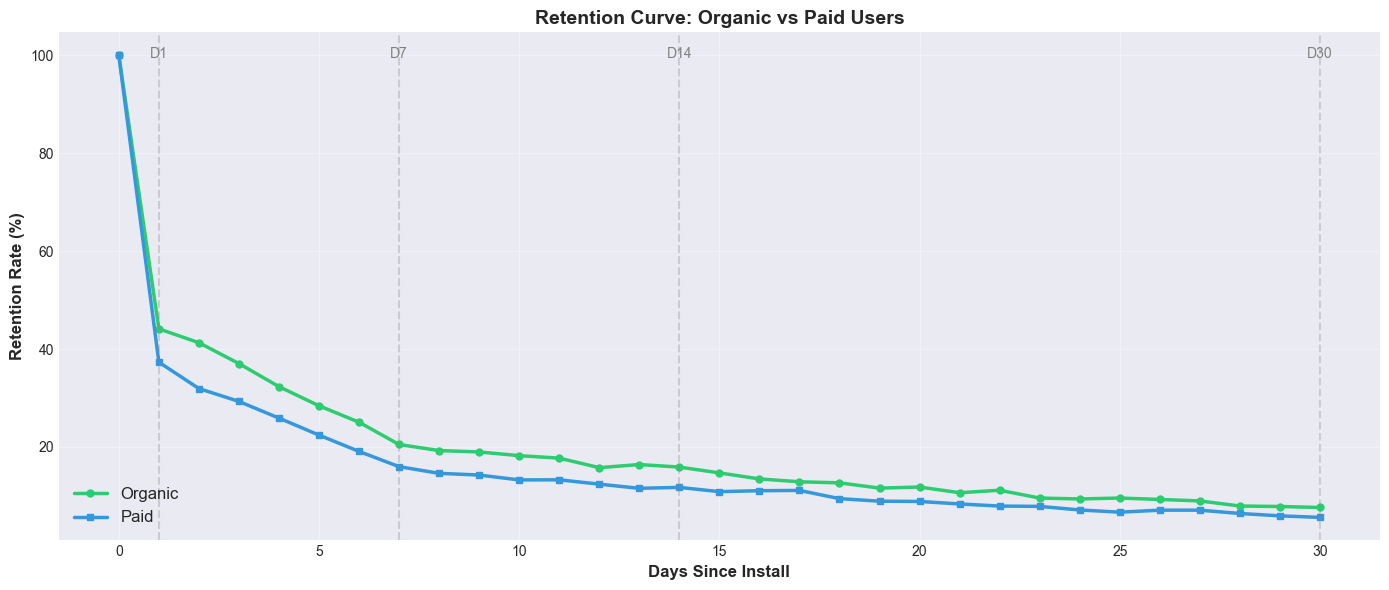

In [88]:
# График 2: Сравнение retention кривых (D0-D30)
# Рассчитываем retention кривые
retention_days = range(0, 31)
organic_retention_curve = []
paid_retention_curve = []

for day in retention_days:
    # Пользователи, у которых есть активность на этот день
    organic_day_active = activities_df[
        (activities_df['user_id'].isin(organic_users['user_id'])) &
        (activities_df['day_since_install'] == day)
    ]['user_id'].nunique()
    
    paid_day_active = activities_df[
        (activities_df['user_id'].isin(paid_users['user_id'])) &
        (activities_df['day_since_install'] == day)
    ]['user_id'].nunique()
    
    organic_retention_curve.append(organic_day_active / len(organic_users) * 100)
    paid_retention_curve.append(paid_day_active / len(paid_users) * 100)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(retention_days, organic_retention_curve, marker='o', linewidth=2.5, 
        label='Organic', color='#2ecc71', markersize=5)
ax.plot(retention_days, paid_retention_curve, marker='s', linewidth=2.5, 
        label='Paid', color='#3498db', markersize=5)

# Выделяем ключевые дни
key_days = [1, 7, 14, 30]
for day in key_days:
    ax.axvline(x=day, color='gray', linestyle='--', alpha=0.3)
    ax.text(day, ax.get_ylim()[1] * 0.95, f'D{day}', ha='center', fontsize=10, color='gray')

ax.set_xlabel('Days Since Install', fontsize=12, fontweight='bold')
ax.set_ylabel('Retention Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Retention Curve: Organic vs Paid Users', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


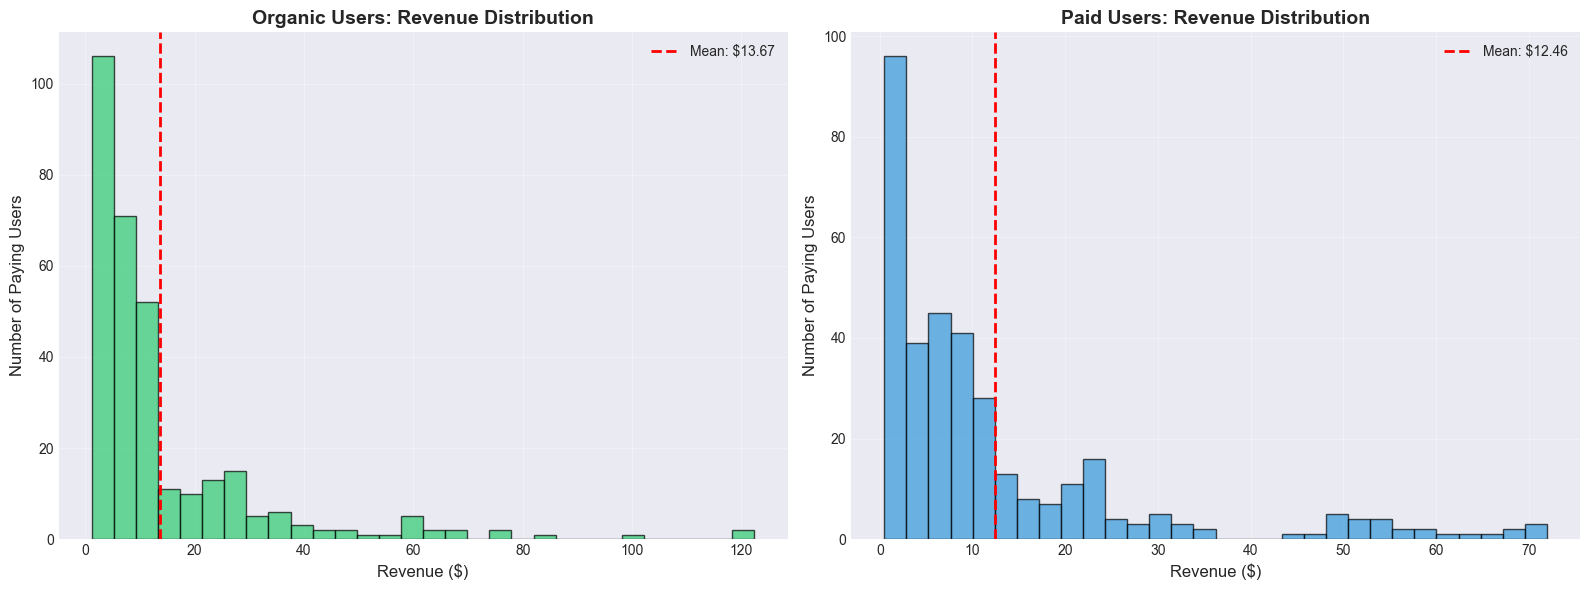

In [89]:
# График 3: Revenue distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Organic revenue distribution
ax1 = axes[0]
organic_revenue = organic_users[organic_users['total_revenue'] > 0]['total_revenue']
ax1.hist(organic_revenue, bins=30, alpha=0.7, color='#2ecc71', edgecolor='black')
ax1.axvline(organic_revenue.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${organic_revenue.mean():.2f}')
ax1.set_xlabel('Revenue ($)', fontsize=12)
ax1.set_ylabel('Number of Paying Users', fontsize=12)
ax1.set_title('Organic Users: Revenue Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Paid revenue distribution  
ax2 = axes[1]
paid_revenue = paid_users[paid_users['total_revenue'] > 0]['total_revenue']
ax2.hist(paid_revenue, bins=30, alpha=0.7, color='#3498db', edgecolor='black')
ax2.axvline(paid_revenue.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: ${paid_revenue.mean():.2f}')
ax2.set_xlabel('Revenue ($)', fontsize=12)
ax2.set_ylabel('Number of Paying Users', fontsize=12)
ax2.set_title('Paid Users: Revenue Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">5. ROAS (Return on Ad Spend)</h2>
</div>

### 📍 Определение

**ROAS (Return on Ad Spend)** — доход, полученный на каждый доллар, потраченный на рекламу.

### 📍 Формула расчета

$$
\text{ROAS} = \frac{\text{Revenue from Paid Users}}{\text{Ad Spend}} \times 100\%
$$

Также можно рассчитывать:
- **Day-X ROAS** — ROAS на определенный день (D7 ROAS, D30 ROAS)
- **Channel ROAS** — по отдельным каналам
- **Campaign ROAS** — по кампаниям

### 📍 Зачем нужна метрика

ROAS — **ключевая метрика окупаемости**, которая:

1. **Показывает прибыльность маркетинга**
   - ROAS > 100% = прибыльное привлечение
   - ROAS < 100% = убыточное привлечение

2. **Используется для принятия решений**
   - Какие каналы масштабировать
   - Какие кампании остановить

3. **Связана с LTV**
   - ROAS на раннем этапе предсказывает итоговую прибыльность

4. **Benchmark для UA**
   - Сравнение с индустрией
   - Target ROAS для различных каналов

### 📍 Что показывает

**По времени:**
- **D7 ROAS** — ранний индикатор (обычно 20-40% от итогового)
- **D30 ROAS** — промежуточная оценка (50-70% от итогового)
- **D90 ROAS** — более точная картина
- **D180+ ROAS** — полная окупаемость

**По уровню:**
- **ROAS < 50%** — критически низкий, убыточный
- **ROAS 50-100%** — низкий, требует улучшения
- **ROAS 100-150%** — break-even до небольшой прибыли
- **ROAS 150-300%** — хороший уровень
- **ROAS > 300%** — отличный уровень

### 📍 На что влияет

✅ **Прибыльность** — напрямую определяет unit economics

✅ **Масштабируемость** — высокий ROAS позволяет масштабировать

✅ **Привлекательность для инвесторов** — ключевая метрика для fundraising

### 📍 Что на нее влияет

✅ **Положительные факторы:**
- Высокий LTV
- Низкий CPI
- Хороший retention
- Высокий paying rate
- Быстрая монетизация (low TTFP)

❌ **Негативные факторы:**
- Низкий LTV
- Высокий CPI
- Плохой retention
- Низкая конверсия в платеж

### 📍 Бенчмарки по жанрам

| Жанр | Good D30 ROAS | Target D180 ROAS | Примечания |
|------|---------------|------------------|------------|
| **Hypercasual** | 80-120% | 150-250% | Быстрая монетизация (ads) |
| **Casual** | 60-100% | 200-400% | Средний цикл монетизации |
| **Mid-core** | 40-80% | 250-500% | Длинный цикл, высокий LTV |
| **Strategy** | 30-70% | 300-600% | Очень длинный цикл |
| **RTS** | 30-60% | 300-700% | Долгая монетизация, лояльные пользователи |
| **RPG** | 40-80% | 250-500% | Зависит от IP и quality |
| **Puzzle** | 70-110% | 180-300% | Быстрая монетизация |

### 📍 Как улучшить

**Увеличить revenue (числитель):**
1. Улучшить retention
2. Увеличить paying rate
3. Оптимизировать monetization
4. Decrease TTFP (time to first purchase)
5. Increase ARPU/ARPPU

**Снизить ad spend (знаменатель):**
1. Снизить CPI (лучшие креативы)
2. Оптимизировать таргетинг
3. Улучшить conversion rate
4. A/B тестирование


### 📍 Расчет на Python


In [90]:
# Расчет ROAS по каналам
roas_by_channel = paid_users.groupby('channel').agg({
    'cpi': 'sum',  # Total spend
    'total_revenue': 'sum'  # Total revenue
}).reset_index()
roas_by_channel.columns = ['channel', 'total_spend', 'total_revenue']
roas_by_channel['roas'] = (roas_by_channel['total_revenue'] / roas_by_channel['total_spend'] * 100).round(2)
roas_by_channel['profit'] = (roas_by_channel['total_revenue'] - roas_by_channel['total_spend']).round(2)
roas_by_channel = roas_by_channel.sort_values('roas', ascending=False)

print("=" * 80)
print("ROAS (RETURN ON AD SPEND) BY CHANNEL")
print("=" * 80)
print(roas_by_channel.to_string(index=False))
print("=" * 80)

# Overall ROAS
total_ad_spend = paid_users['cpi'].sum()
total_revenue_paid = paid_users['total_revenue'].sum()
overall_roas = (total_revenue_paid / total_ad_spend * 100)

print(f"\nOverall ROAS: {overall_roas:.2f}%")
print(f"Total Ad Spend: ${total_ad_spend:,.2f}")
print(f"Total Revenue (Paid Users): ${total_revenue_paid:,.2f}")
print(f"Profit/Loss: ${(total_revenue_paid - total_ad_spend):,.2f}")

# ROAS по creative
roas_by_creative = paid_users.groupby('creative').agg({
    'cpi': 'sum',
    'total_revenue': 'sum'
}).reset_index()
roas_by_creative.columns = ['creative', 'total_spend', 'total_revenue']
roas_by_creative['roas'] = (roas_by_creative['total_revenue'] / roas_by_creative['total_spend'] * 100).round(2)
roas_by_creative = roas_by_creative.sort_values('roas', ascending=False)

print(f"\nROAS by Creative:")
print(roas_by_creative.to_string(index=False))


ROAS (RETURN ON AD SPEND) BY CHANNEL
   channel  total_spend  total_revenue  roas   profit
  Facebook      9428.08        2390.97 25.36 -7037.11
    TikTok      4076.68         628.00 15.40 -3448.68
Google UAC      7508.64        1131.10 15.06 -6377.54
  AppLovin       679.52          60.98  8.97  -618.54
 Unity Ads      1393.09         103.96  7.46 -1289.13
ironSource       416.88          19.96  4.79  -396.92

Overall ROAS: 18.44%
Total Ad Spend: $23,502.89
Total Revenue (Paid Users): $4,334.97
Profit/Loss: $-19,167.92

ROAS by Creative:
  creative  total_spend  total_revenue  roas
Creative_D      5798.39        1133.12 19.54
Creative_A      5931.78        1128.20 19.02
Creative_C      5899.25        1043.18 17.68
Creative_B      5873.47        1030.47 17.54


### 📍 Визуализация


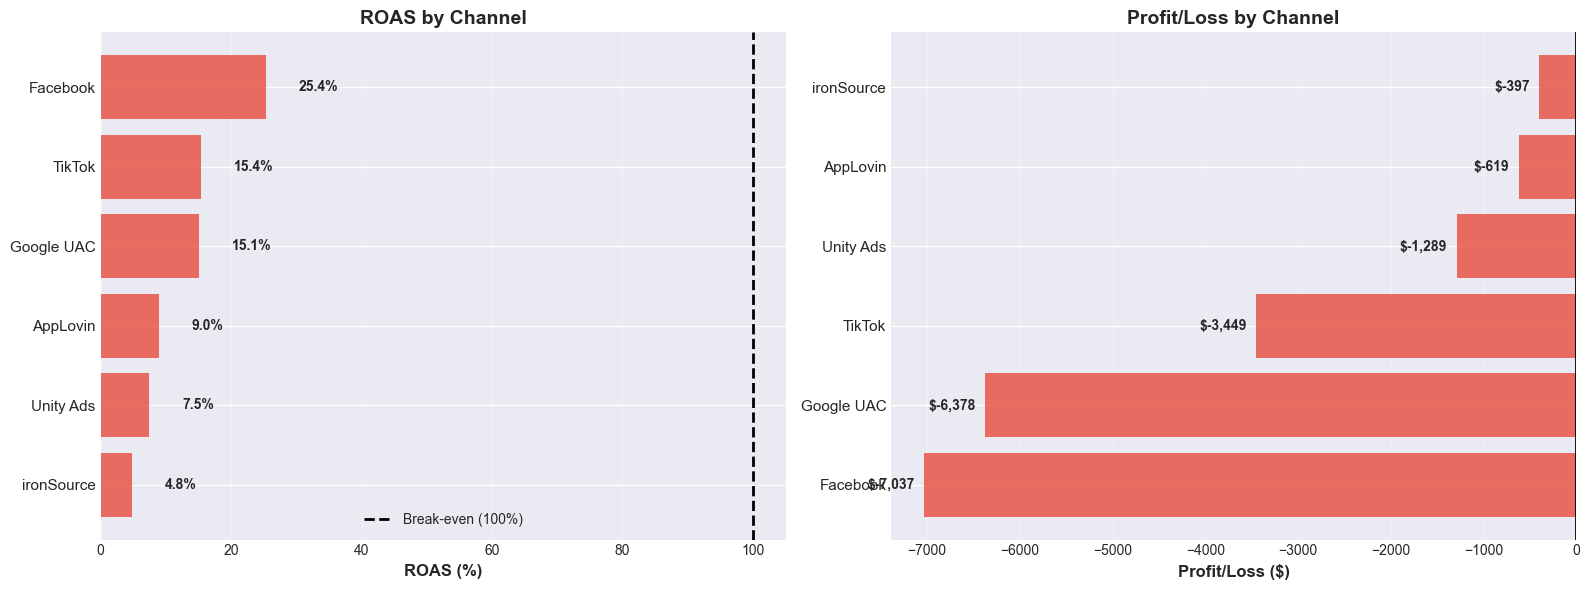

In [91]:
# График 1: ROAS по каналам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROAS bar chart
ax1 = axes[0]
roas_sorted = roas_by_channel.sort_values('roas', ascending=True)
colors = ['#e74c3c' if x < 100 else '#f39c12' if x < 150 else '#2ecc71' for x in roas_sorted['roas']]
bars = ax1.barh(range(len(roas_sorted)), roas_sorted['roas'], color=colors, alpha=0.8)

# Добавляем линию break-even
ax1.axvline(x=100, color='black', linestyle='--', linewidth=2, label='Break-even (100%)')

for i, value in enumerate(roas_sorted['roas']):
    ax1.text(value + 5, i, f'{value:.1f}%', va='center', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(roas_sorted)))
ax1.set_yticklabels(roas_sorted['channel'], fontsize=11)
ax1.set_xlabel('ROAS (%)', fontsize=12, fontweight='bold')
ax1.set_title('ROAS by Channel', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Profit/Loss bar chart
ax2 = axes[1]
profit_sorted = roas_by_channel.sort_values('profit', ascending=True)
colors2 = ['#e74c3c' if x < 0 else '#2ecc71' for x in profit_sorted['profit']]
bars2 = ax2.barh(range(len(profit_sorted)), profit_sorted['profit'], color=colors2, alpha=0.8)

for i, value in enumerate(profit_sorted['profit']):
    ax2.text(value + (100 if value >= 0 else -100), i, f'${value:,.0f}', 
            va='center', ha='left' if value >= 0 else 'right', fontsize=10, fontweight='bold')

ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax2.set_yticks(range(len(profit_sorted)))
ax2.set_yticklabels(profit_sorted['channel'], fontsize=11)
ax2.set_xlabel('Profit/Loss ($)', fontsize=12, fontweight='bold')
ax2.set_title('Profit/Loss by Channel', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


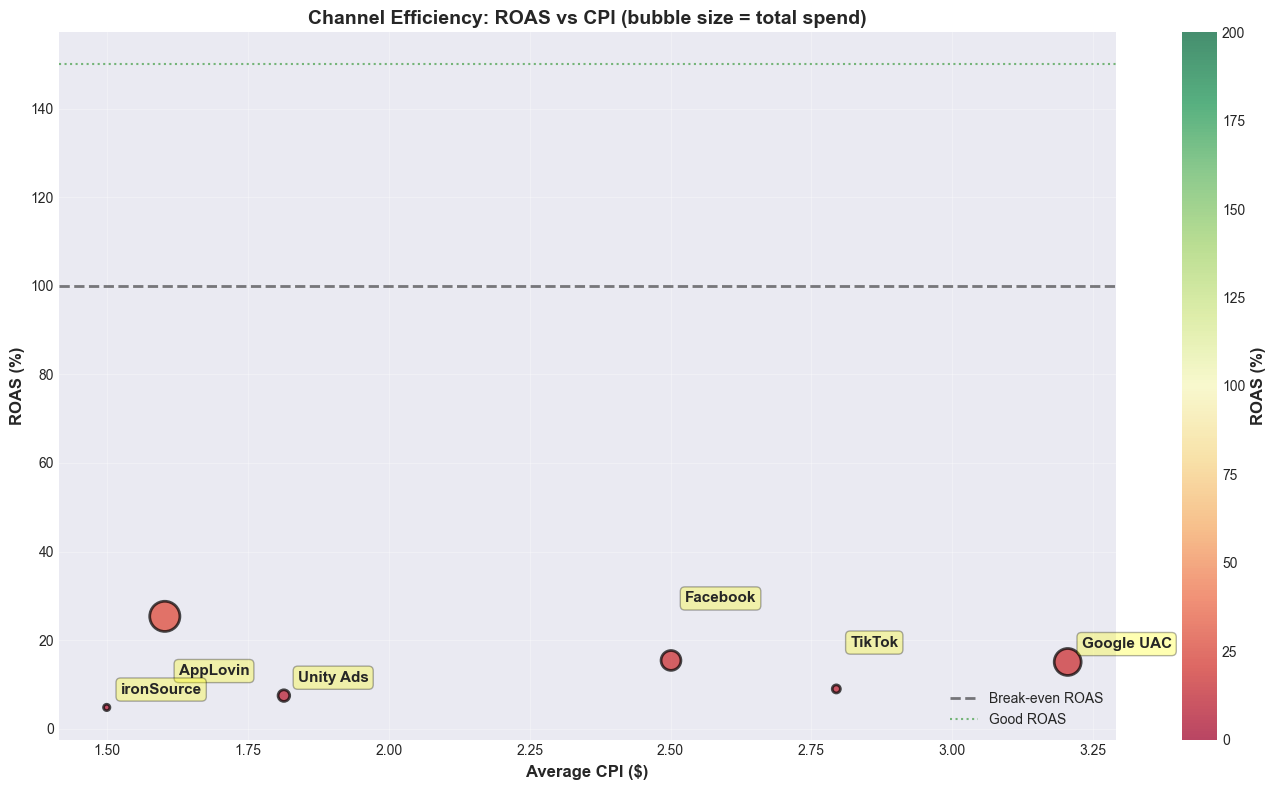

In [92]:
# График 2: Scatter - ROAS vs CPI (эффективность каналов)
fig, ax = plt.subplots(figsize=(14, 8))

# Средний CPI по каналу
avg_cpi_channel = paid_users.groupby('channel')['cpi'].mean()

scatter = ax.scatter(avg_cpi_channel, 
                     roas_by_channel.set_index('channel')['roas'],
                     s=roas_by_channel.set_index('channel')['total_spend']*0.05,
                     c=roas_by_channel.set_index('channel')['roas'],
                     cmap='RdYlGn',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=2,
                     vmin=0,
                     vmax=200)

# Добавляем названия каналов
for channel in roas_by_channel['channel']:
    x = avg_cpi_channel[channel]
    y = roas_by_channel[roas_by_channel['channel'] == channel]['roas'].values[0]
    ax.annotate(channel, (x, y), xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Линии разделения
ax.axhline(y=100, color='black', linestyle='--', linewidth=2, label='Break-even ROAS', alpha=0.5)
ax.axhline(y=150, color='green', linestyle=':', linewidth=1.5, label='Good ROAS', alpha=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('ROAS (%)', fontsize=12, fontweight='bold')

ax.set_xlabel('Average CPI ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('ROAS (%)', fontsize=12, fontweight='bold')
ax.set_title('Channel Efficiency: ROAS vs CPI (bubble size = total spend)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #4facfe;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">6. LTV/CAC Ratio</h2>
</div>

### 📍 Определение

**LTV/CAC Ratio** — отношение пожизненной ценности пользователя (LTV) к стоимости его привлечения (CAC).

### 📍 Формула расчета

$$
\text{LTV/CAC Ratio} = \frac{\text{LTV (Lifetime Value)}}{\text{CAC (Customer Acquisition Cost)}}
$$

Где:
- **LTV** = Средний доход на пользователя за весь жизненный цикл
- **CAC** = CPI для платных пользователей, 0 для органических

### 📍 Зачем нужна метрика

LTV/CAC — **главная метрика unit economics**, которая:

1. **Определяет прибыльность бизнеса**
   - LTV/CAC > 3 = здоровый бизнес
   - LTV/CAC < 1 = убыточный бизнес

2. **Показывает масштабируемость**
   - Высокий ratio = можно масштабировать UA
   - Низкий ratio = проблемы с экономикой

3. **Критична для инвесторов**
   - Ключевая метрика для fundraising
   - Показывает долгосрочную жизнеспособность

4. **Используется для принятия решений**
   - Сколько тратить на UA
   - Какие каналы приоритезировать

### 📍 Что показывает

**Интерпретация:**
- **LTV/CAC < 1** — убыток на каждом пользователе (критично!)
- **LTV/CAC 1-2** — слабая экономика, риск
- **LTV/CAC 2-3** — break-even до небольшой прибыли
- **LTV/CAC 3-5** — хорошая экономика
- **LTV/CAC > 5** — отличная экономика, масштабируемо

**Важно:** Нужно также учитывать **Payback Period**
- LTV/CAC может быть высоким, но с долгой окупаемостью
- Ideal: LTV/CAC > 3 AND Payback < 12 месяцев

### 📍 На что влияет

✅ **Прибыльность** — напрямую определяет profit margin

✅ **Масштабируемость** — показывает, сколько можно тратить на UA

✅ **Привлекательность для инвесторов** — ключевая метрика для оценки

✅ **Runway** — сколько компания проживет на текущих средствах

### 📍 Что на нее влияет

**На LTV (числитель):**
✅ Retention
✅ Monetization
✅ Paying rate
✅ ARPU/ARPPU

**На CAC (знаменатель):**
✅ CPI
✅ Organic rate (органика снижает средний CAC)
✅ Креативы
✅ Таргетинг

### 📍 Бенчмарки по жанрам

| Жанр | Target LTV/CAC | Min Acceptable | Примечания |
|------|----------------|----------------|------------|
| **Hypercasual** | 2-3 | 1.5 | Низкий LTV, низкий CPI |
| **Casual** | 3-5 | 2.5 | Средний LTV, средний CPI |
| **Mid-core** | 4-7 | 3 | Высокий LTV |
| **Strategy** | 5-10 | 3.5 | Очень высокий LTV |
| **RTS** | 5-12 | 4 | Долгий lifecycle, лояльные пользователи |
| **RPG** | 4-8 | 3 | Зависит от IP |
| **Puzzle** | 3-5 | 2 | Быстрая монетизация |

### 📍 Как улучшить

**Увеличить LTV:**
1. Улучшить retention (дольше играют = больше платят)
2. Increase paying conversion rate
3. Optimize monetization (pricing, offers)
4. Add content (увеличить lifetime)
5. Improve onboarding

**Снизить CAC:**
1. Снизить CPI (лучшие креативы)
2. Increase organic share
3. Improve targeting
4. Better attribution
5. Optimize channels


### 📍 Расчет на Python


In [93]:
# Расчет LTV/CAC по каналам
ltv_cac_by_channel = paid_users.groupby('channel').agg({
    'total_revenue': 'mean',  # Average LTV
    'cpi': 'mean'  # Average CAC
}).reset_index()
ltv_cac_by_channel.columns = ['channel', 'avg_ltv', 'avg_cac']
ltv_cac_by_channel['ltv_cac_ratio'] = (ltv_cac_by_channel['avg_ltv'] / ltv_cac_by_channel['avg_cac']).round(2)
ltv_cac_by_channel = ltv_cac_by_channel.sort_values('ltv_cac_ratio', ascending=False)

print("=" * 70)
print("LTV/CAC RATIO BY CHANNEL")
print("=" * 70)
print(ltv_cac_by_channel.to_string(index=False))
print("=" * 70)

# Overall metrics
overall_ltv_paid = paid_users['total_revenue'].mean()
overall_cac = paid_users['cpi'].mean()
overall_ltv_cac = overall_ltv_paid / overall_cac

print(f"\nOverall Metrics (Paid Users):")
print(f"  Average LTV: ${overall_ltv_paid:.2f}")
print(f"  Average CAC: ${overall_cac:.2f}")
print(f"  LTV/CAC Ratio: {overall_ltv_cac:.2f}")

# Включая органику (CAC = 0 для них, считаем blended CAC)
total_ltv_all = users_df['total_revenue'].mean()
blended_cac = paid_users['cpi'].sum() / len(users_df)  # Total spend / Total users
blended_ltv_cac = total_ltv_all / blended_cac if blended_cac > 0 else float('inf')

print(f"\nBlended Metrics (Including Organic):")
print(f"  Average LTV (All Users): ${total_ltv_all:.2f}")
print(f"  Blended CAC: ${blended_cac:.2f}")
print(f"  Blended LTV/CAC Ratio: {blended_ltv_cac:.2f}")

# Оценка здоровья бизнеса
print(f"\n💡 Business Health Assessment:")
if overall_ltv_cac >= 3:
    print(f"   ✅ Healthy unit economics (LTV/CAC = {overall_ltv_cac:.2f} >= 3)")
elif overall_ltv_cac >= 2:
    print(f"   ⚠️ Marginal unit economics (LTV/CAC = {overall_ltv_cac:.2f}, target >= 3)")
else:
    print(f"   ❌ Unhealthy unit economics (LTV/CAC = {overall_ltv_cac:.2f} < 2)")


LTV/CAC RATIO BY CHANNEL
   channel  avg_ltv  avg_cac  ltv_cac_ratio
  Facebook 0.634210 2.500817           0.25
Google UAC 0.482757 3.204712           0.15
    TikTok 0.430432 2.794160           0.15
  AppLovin 0.143821 1.602642           0.09
 Unity Ads 0.135365 1.813919           0.07
ironSource 0.071799 1.499568           0.05

Overall Metrics (Paid Users):
  Average LTV: $0.48
  Average CAC: $2.60
  LTV/CAC Ratio: 0.18

Blended Metrics (Including Organic):
  Average LTV (All Users): $0.57
  Blended CAC: $1.57
  Blended LTV/CAC Ratio: 0.37

💡 Business Health Assessment:
   ❌ Unhealthy unit economics (LTV/CAC = 0.18 < 2)


### 📍 Визуализация


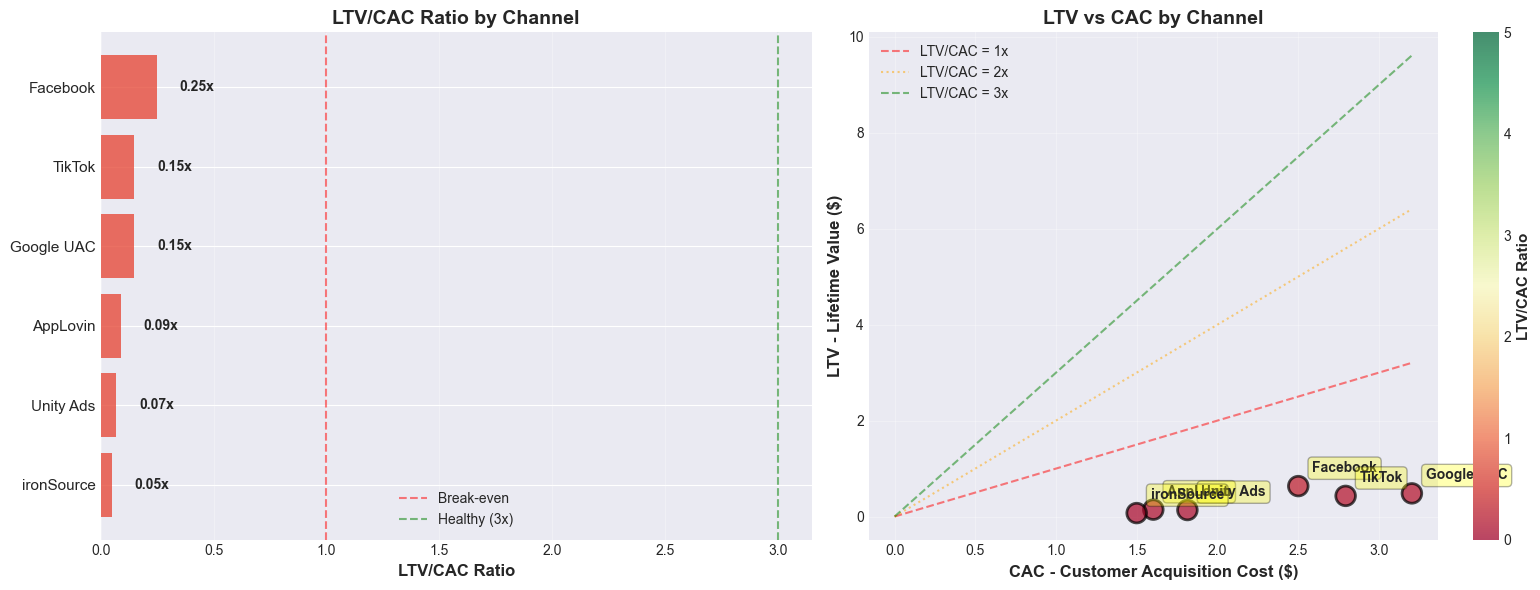

In [94]:
# График 1: LTV/CAC Ratio по каналам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LTV/CAC bar chart
ax1 = axes[0]
ratio_sorted = ltv_cac_by_channel.sort_values('ltv_cac_ratio', ascending=True)
colors = ['#e74c3c' if x < 2 else '#f39c12' if x < 3 else '#2ecc71' for x in ratio_sorted['ltv_cac_ratio']]
bars = ax1.barh(range(len(ratio_sorted)), ratio_sorted['ltv_cac_ratio'], color=colors, alpha=0.8)

# Добавляем reference lines
ax1.axvline(x=1, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Break-even')
ax1.axvline(x=3, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Healthy (3x)')

for i, value in enumerate(ratio_sorted['ltv_cac_ratio']):
    ax1.text(value + 0.1, i, f'{value:.2f}x', va='center', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(ratio_sorted)))
ax1.set_yticklabels(ratio_sorted['channel'], fontsize=11)
ax1.set_xlabel('LTV/CAC Ratio', fontsize=12, fontweight='bold')
ax1.set_title('LTV/CAC Ratio by Channel', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# LTV vs CAC scatter
ax2 = axes[1]
scatter = ax2.scatter(ltv_cac_by_channel['avg_cac'], 
                      ltv_cac_by_channel['avg_ltv'],
                      s=200,
                      c=ltv_cac_by_channel['ltv_cac_ratio'],
                      cmap='RdYlGn',
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=2,
                      vmin=0,
                      vmax=5)

for idx, row in ltv_cac_by_channel.iterrows():
    ax2.annotate(row['channel'], 
                 (row['avg_cac'], row['avg_ltv']),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Добавляем линии 1x, 2x, 3x
max_val = max(ltv_cac_by_channel['avg_cac'].max(), ltv_cac_by_channel['avg_ltv'].max())
x_range = np.linspace(0, max_val, 100)
ax2.plot(x_range, x_range, 'r--', alpha=0.5, label='LTV/CAC = 1x')
ax2.plot(x_range, x_range * 2, 'orange', linestyle=':', alpha=0.5, label='LTV/CAC = 2x')
ax2.plot(x_range, x_range * 3, 'g--', alpha=0.5, label='LTV/CAC = 3x')

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('LTV/CAC Ratio', fontsize=11, fontweight='bold')

ax2.set_xlabel('CAC - Customer Acquisition Cost ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('LTV - Lifetime Value ($)', fontsize=12, fontweight='bold')
ax2.set_title('LTV vs CAC by Channel', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<div style="padding: 2em; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 12px; color: white; margin: 2em 0;">
  <h2 style="margin: 0 0 0.5em 0; font-size: 2em; font-weight: 600;">Comprehensive Summary & Best Practices</h2>
</div>

## 📍 User Acquisition Framework

### Ключевые принципы эффективного UA:

**1. Экономика превыше всего**
- **LTV/CAC > 3** — минимальный здоровый уровень
- **Payback < 12 месяцев** — для масштабируемости
- **ROAS > 150% за D180** — целевой показатель

**2. Органика — фундамент роста**
- Aim for **35-45%+ organic share**
- Лучше retention, LTV, paying rate
- Снижает blended CAC

**3. Креативы решают все**
- **IPM — главный индикатор** эффективности
- A/B тестирование 4-6 вариантов минимум
- Refresh каждые 2-4 недели (ad fatigue)

**4. Диверсификация каналов**
- Don't rely on a single channel (риск)
- Test new channels continuously
- Balance между scale и efficiency

**5. Data-driven подход**
- Track full funnel (impressions → revenue)
- Cohort analysis для каждого канала
- Attribution для понимания customer journey

### 📍 Red Flags в User Acquisition

**❌ Критические проблемы:**

1. **LTV/CAC < 1** — Immediate action needed
   - Stop spending or reduce dramatically
   - Fix retention and monetization first

2. **CPI растет, а качество падает**
   - Ad fatigue
   - Неправильный таргетинг
   - Creative exhaustion

3. **Низкий D1 Retention (<25%) при платном трафике**
   - Misleading creatives
   - Poor onboarding
   - Wrong audience

4. **ROAS не растет со временем**
   - Проблемы с retention
   - Слабая монетизация
   - Короткий lifecycle

5. **Зависимость от одного канала (>60%)**
   - Огромный риск
   - Нет negotiation power
   - Уязвимость к изменениям (iOS 14.5)

6. **Organic rate падает**
   - Product-market fit ухудшается
   - ASO проблемы
   - Конкуренция растет

### 📍 UA Strategy по жанрам

**Hypercasual:**
- Фокус на **volume**, низкий CPI (<$1)
- Aggressive testing (10+ creatives/week)
- Fast iteration
- Преимущественно video ads
- Key metric: IPM

**Casual/Mid-core:**
- Balance между volume и quality
- CPI $2-5
- Strong onboarding
- Mix of ad formats
- Key metrics: D1 Retention + LTV/CAC

**RTS/Strategy:**
- Focus on **quality**, высокий LTV
- Higher CPI acceptable ($5-15)
- Long-term thinking
- Strong community
- Key metrics: D7/D30 Retention, LTV/CAC

### 📍 Channel Optimization Framework

**1. Testing Phase (Week 1-2)**
- Small budget ($500-1000/channel)
- Multiple creatives (4-6)
- Measure: CPI, IPM, D1 Retention

**2. Learning Phase (Week 3-4)**
- Increase budget on winning creative
- Expand audiences
- Measure: D7 Retention, early LTV

**3. Scaling Phase (Month 2+)**
- Scale winners (ROAS > target)
- Maintain creative refresh
- Monitor quality metrics

**4. Optimization Phase (Ongoing)**
- Bid optimization
- Audience refinement
- Creative iteration
- Channel mix rebalancing


## 📍 Final UA Dashboard

Создадим comprehensive dashboard со всеми ключевыми UA метриками:


KeyError: 'channel'

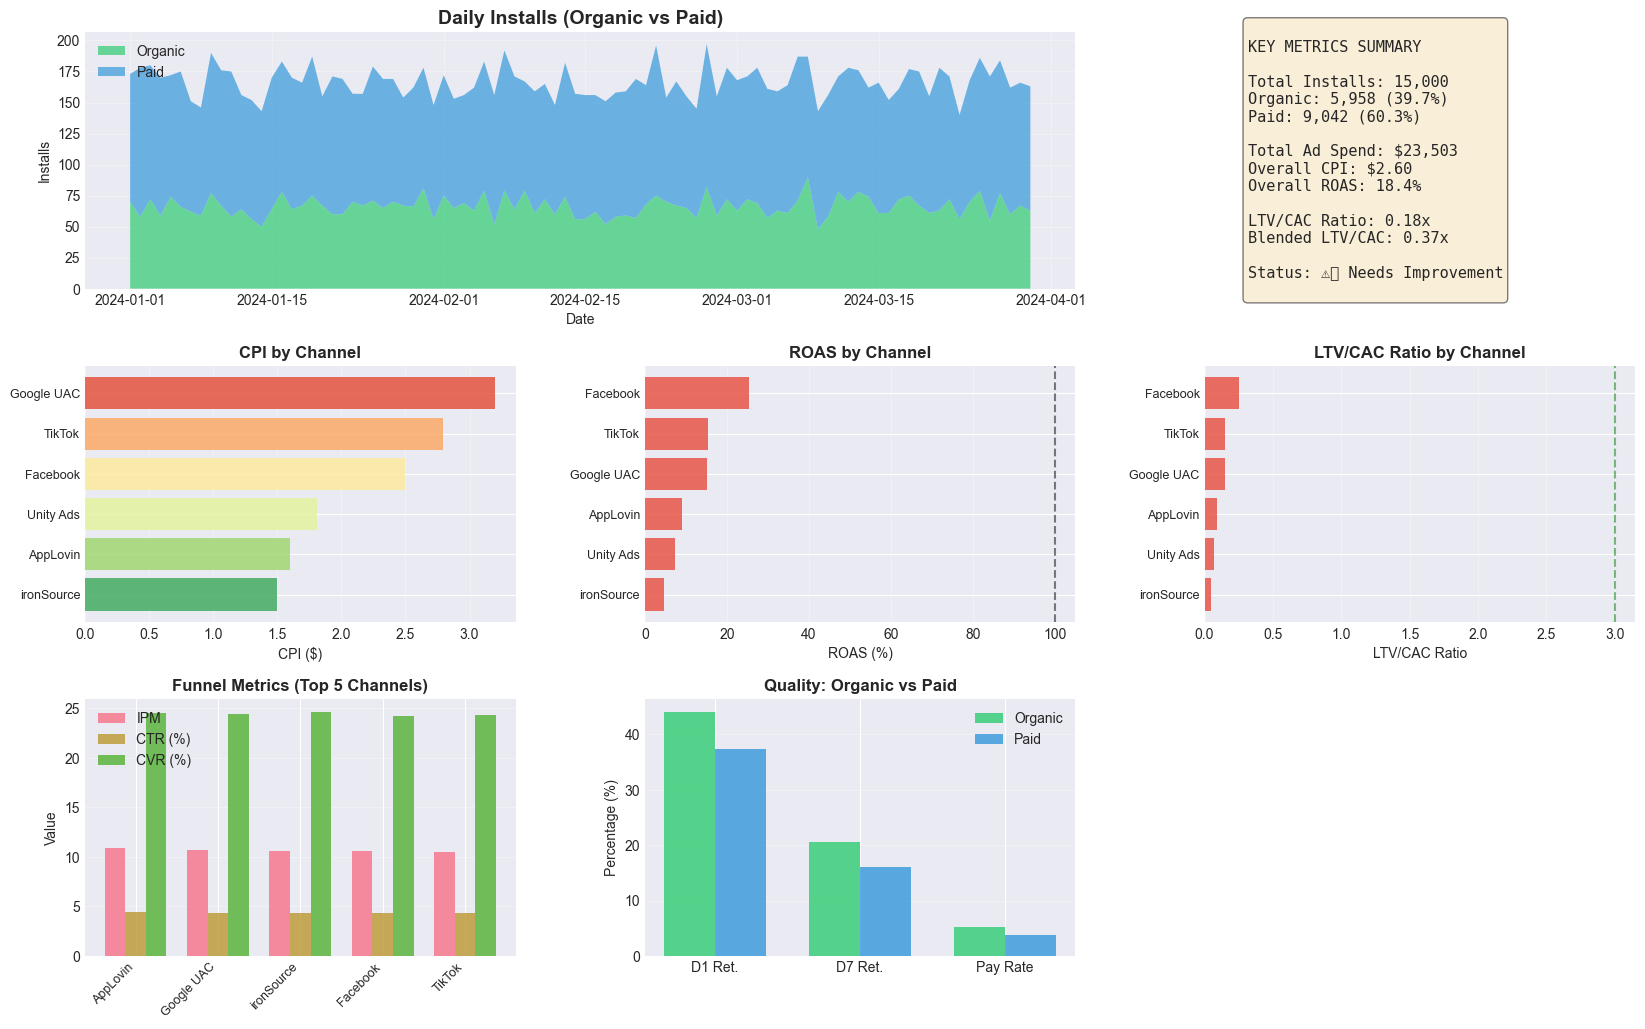

In [95]:
# Создаем comprehensive UA dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Installs Over Time
ax1 = fig.add_subplot(gs[0, :2])
daily_by_type = users_df.groupby(['install_date', 'channel_type']).size().unstack(fill_value=0)
ax1.stackplot(daily_by_type.index, 
              daily_by_type.get('Organic', 0),
              daily_by_type.get('Paid', 0),
              labels=['Organic', 'Paid'],
              colors=['#2ecc71', '#3498db'],
              alpha=0.7)
ax1.set_title('Daily Installs (Organic vs Paid)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Installs')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Key Metrics Summary
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
summary_text = f"""
KEY METRICS SUMMARY

Total Installs: {len(users_df):,}
Organic: {organic_installs:,} ({organic_installs/total_installs*100:.1f}%)
Paid: {paid_installs:,} ({paid_installs/total_installs*100:.1f}%)

Total Ad Spend: ${total_ad_spend:,.0f}
Overall CPI: ${overall_cpi:.2f}
Overall ROAS: {overall_roas:.1f}%

LTV/CAC Ratio: {overall_ltv_cac:.2f}x
Blended LTV/CAC: {blended_ltv_cac:.2f}x

Status: {'✅ Healthy' if overall_ltv_cac >= 3 else '⚠️ Needs Improvement'}
"""
ax2.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         family='monospace')

# 3. CPI by Channel
ax3 = fig.add_subplot(gs[1, 0])
cpi_data = cpi_by_channel.sort_values('Avg CPI', ascending=True)
colors3 = sns.color_palette('RdYlGn_r', len(cpi_data))
ax3.barh(range(len(cpi_data)), cpi_data['Avg CPI'], color=colors3, alpha=0.8)
ax3.set_yticks(range(len(cpi_data)))
ax3.set_yticklabels(cpi_data.index, fontsize=9)
ax3.set_xlabel('CPI ($)')
ax3.set_title('CPI by Channel', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. ROAS by Channel
ax4 = fig.add_subplot(gs[1, 1])
roas_data = roas_by_channel.sort_values('roas', ascending=True)
colors4 = ['#e74c3c' if x < 100 else '#f39c12' if x < 150 else '#2ecc71' for x in roas_data['roas']]
ax4.barh(range(len(roas_data)), roas_data['roas'], color=colors4, alpha=0.8)
ax4.axvline(x=100, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax4.set_yticks(range(len(roas_data)))
ax4.set_yticklabels(roas_data['channel'], fontsize=9)
ax4.set_xlabel('ROAS (%)')
ax4.set_title('ROAS by Channel', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. LTV/CAC Ratio by Channel
ax5 = fig.add_subplot(gs[1, 2])
ltv_cac_data = ltv_cac_by_channel.sort_values('ltv_cac_ratio', ascending=True)
colors5 = ['#e74c3c' if x < 2 else '#f39c12' if x < 3 else '#2ecc71' for x in ltv_cac_data['ltv_cac_ratio']]
ax5.barh(range(len(ltv_cac_data)), ltv_cac_data['ltv_cac_ratio'], color=colors5, alpha=0.8)
ax5.axvline(x=3, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
ax5.set_yticks(range(len(ltv_cac_data)))
ax5.set_yticklabels(ltv_cac_data['channel'], fontsize=9)
ax5.set_xlabel('LTV/CAC Ratio')
ax5.set_title('LTV/CAC Ratio by Channel', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. Funnel Metrics
ax6 = fig.add_subplot(gs[2, 0])
funnel_summary = funnel_by_channel_sorted[['channel', 'ipm', 'ctr', 'cvr']].head(5)
x = np.arange(len(funnel_summary))
width = 0.25
ax6.bar(x - width, funnel_summary['ipm'], width, label='IPM', alpha=0.8)
ax6.bar(x, funnel_summary['ctr'], width, label='CTR (%)', alpha=0.8)
ax6.bar(x + width, funnel_summary['cvr'], width, label='CVR (%)', alpha=0.8)
ax6.set_xticks(x)
ax6.set_xticklabels(funnel_summary['channel'], rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('Value')
ax6.set_title('Funnel Metrics (Top 5 Channels)', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 7. Quality Metrics Comparison (Organic vs Paid)
ax7 = fig.add_subplot(gs[2, 1])
categories = ['D1 Ret.', 'D7 Ret.', 'Pay Rate']
organic_vals = [
    organic_users['d1_retained'].mean() * 100,
    organic_users['d7_retained'].mean() * 100,
    (organic_users['total_revenue'] > 0).mean() * 100
]
paid_vals = [
    paid_users['d1_retained'].mean() * 100,
    paid_users['d7_retained'].mean() * 100,
    (paid_users['total_revenue'] > 0).mean() * 100
]
x = np.arange(len(categories))
width = 0.35
ax7.bar(x - width/2, organic_vals, width, label='Organic', color='#2ecc71', alpha=0.8)
ax7.bar(x + width/2, paid_vals, width, label='Paid', color='#3498db', alpha=0.8)
ax7.set_xticks(x)
ax7.set_xticklabels(categories)
ax7.set_ylabel('Percentage (%)')
ax7.set_title('Quality: Organic vs Paid', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# 8. Channel Performance Matrix
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
channel_summary = """
CHANNEL PERFORMANCE

Best CPI: {best_cpi_ch}
Best ROAS: {best_roas_ch}
Best LTV/CAC: {best_ltv_cac_ch}

Recommendations:
✅ Scale: {scale_ch}
⚠️ Monitor: {monitor_ch}
❌ Review: {review_ch}
""".format(
    best_cpi_ch=cpi_by_channel.iloc[0]['channel'],
    best_roas_ch=roas_by_channel.iloc[0]['channel'],
    best_ltv_cac_ch=ltv_cac_by_channel.iloc[0]['channel'],
    scale_ch=ltv_cac_by_channel[ltv_cac_by_channel['ltv_cac_ratio'] >= 3]['channel'].tolist()[0] if len(ltv_cac_by_channel[ltv_cac_by_channel['ltv_cac_ratio'] >= 3]) > 0 else 'None',
    monitor_ch=ltv_cac_by_channel[(ltv_cac_by_channel['ltv_cac_ratio'] >= 2) & (ltv_cac_by_channel['ltv_cac_ratio'] < 3)]['channel'].tolist()[0] if len(ltv_cac_by_channel[(ltv_cac_by_channel['ltv_cac_ratio'] >= 2) & (ltv_cac_by_channel['ltv_cac_ratio'] < 3)]) > 0 else 'None',
    review_ch=ltv_cac_by_channel[ltv_cac_by_channel['ltv_cac_ratio'] < 2]['channel'].tolist()[0] if len(ltv_cac_by_channel[ltv_cac_by_channel['ltv_cac_ratio'] < 2]) > 0 else 'None'
)
ax8.text(0.1, 0.5, channel_summary, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
         family='monospace')

plt.suptitle('USER ACQUISITION DASHBOARD', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DASHBOARD GENERATED SUCCESSFULLY")
print("="*80)


<div style="padding: 2em; background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); border-radius: 12px; color: white; margin: 2em 0;">
  <h2 style="margin: 0; font-size: 2em; font-weight: 600;">Заключение</h2>
</div>

## 📍 Key Takeaways

### Самые важные UA метрики:

1. **CPI** — стоимость привлечения
2. **LTV/CAC Ratio** — главная метрика unit economics  
3. **ROAS** — окупаемость рекламы
4. **IPM & CTR** — эффективность креативов
5. **Organic vs Paid** — качество роста

### Вопросы на интервью:

**Q: Как оцениваешь эффективность UA канала?**

A: CPI + качество (D1/D7 retention) + ROAS + LTV/CAC + масштабируемость

**Q: Что делать если CPI растет?**

A: Обновить креативы, проверить таргетинг, тестировать новые аудитории

**Q: Как определить target CPI?**

A: target CPI = LTV / 3 (для LTV/CAC > 3)

---

<div style="padding: 1.5em; background: #e8f5e9; border-left: 4px solid #4caf50; border-radius: 6px;">
  <p style="margin: 0; color: #2c3e50; line-height: 1.8;">
    <strong>✅ Завершение:</strong> Этот ноутбук покрывает все ключевые метрики User Acquisition для работы игровым аналитиком.
  </p>
</div>

**Good luck! 🚀**
